# CloudSat collocations - Preprocessing

This notebook combines TIWP estimates from the various cloud datasets that were collocated with CloudSat estimates into single files.

In [1]:
from pathlib import Path
from typing import Dict

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

In [2]:
LAT_LIMITS = (-70, 69)

> **NOTE**:  The CloudSat-CCIC collocations only contain profiles within (-70, 69). Therefore, only those profiles are extracted here.

## ISCCP

The following steps are used here to extract TIWP estimates from ISCCP files:

1. Load cloud type amount (``cldamt_types``) and mask values outside the valid range $[-500, 500]$ as defined in the variable description
2. Load cloud water path by type (``wp_type``) and mask values outside the valid range $[-500, 500]$ as defined in the variable description
3. Load ``scene`` variable and maks night-time pixels, which have mask values $\geq 100$

The third step is necessary because ``wp_type`` is available only during day and for cloudy pixels thus making it impossible to distinguish non-cloudy and night-time pixels. ``cldamt_types``, however, is calculated for both day-time and night-time pixels thus not providing any way to discriminate day-time and night-time pixels.

In [3]:
isccp_data = xr.load_dataset("/data/satellite_data/isccp/ISCCP-Basic.HGG.v01r00.GLOBAL.2006.06.02.1500.GPC.10KM.CS00.EA1.00.nc")
cloud_types = isccp_data.cloud_type_label
frozen_cloud_mask = np.array(
    ["_ice" in cloud_type.decode() for cloud_type in cloud_types.data]
)

In [144]:
isccp_data.lon

<xarray.DataArray 'lon' (lon: 360)>
array([  0.5,   1.5,   2.5, ..., 357.5, 358.5, 359.5], dtype=float32)
Coordinates:
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Attributes:
    long_name:      Center longitude of square grid cell
    units:          degrees_east
    valid_min:      0.0
    valid_max:      360.0
    bounds:         lon_bounds
    standard_name:  longitude
    axis:           X

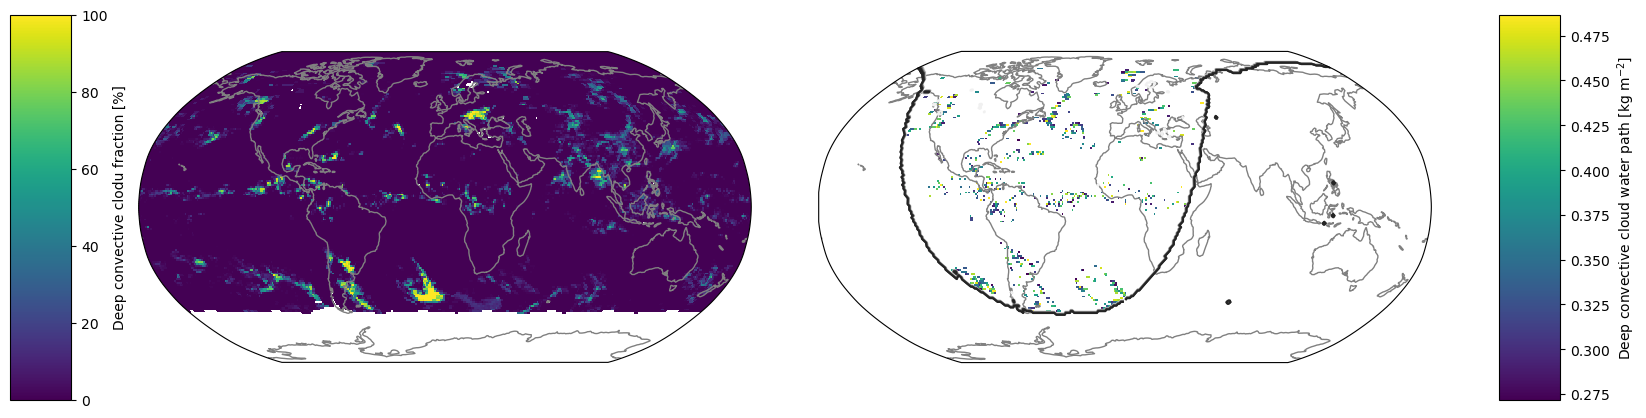

In [4]:
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec

crs = ccrs.Robinson()

fig = plt.figure(figsize=(20, 5))
gs = GridSpec(1, 4, width_ratios=[0.1, 1.0, 1.0, 0.1])

# CLDAMT
ax = fig.add_subplot(gs[0, 1], projection=crs)
cldamt_dc = isccp_data.cldamt_types[0, -1].data.copy()
invalid = (cldamt_dc < -500) + (cldamt_dc > 500)
cldamt_dc[invalid] = np.nan
lats = isccp_data.lat.data
lons = isccp_data.lon.data
m = ax.pcolormesh(lons, lats, cldamt_dc, transform=ccrs.PlateCarree())
ax.coastlines(color="grey")

cax = fig.add_subplot(gs[0, 0])
plt.colorbar(m, cax=cax, label="Deep convective clodu fraction [%]")

# WP
ax = fig.add_subplot(gs[0, 2], projection=crs)
wp_dc = isccp_data.wp_type[0, -1].data.copy()
invalid = (wp_dc < -500) + (wp_dc > 500)
wp_dc[invalid] = np.nan
lats = isccp_data.lat.data
lons = isccp_data.lon.data
scene = isccp_data.scene.data[0]
m = ax.pcolormesh(lons, lats, wp_dc / 1e3, transform=ccrs.PlateCarree())
ax.contour(lons, lats, scene, cmap="Greys", transform=ccrs.PlateCarree())
ax.coastlines(color="grey")

cax = fig.add_subplot(gs[0, 3])
plt.colorbar(m, cax=cax, label="Deep convective cloud water path [kg m$^{-2}$]")

In [81]:
def get_tiwp_isccp(dataset: xr.Dataset) -> xr.DataArray:
    """
    Determine ISCCP TIWP from collocation file.

    Args:
        dataset: A xarray.Dataset containing ISCCP-CloudSat collocations.

    Return:
        A DataArray containing the extracted TIWP
    """
    lat_mask = (LAT_LIMITS[0] < dataset.latitude) * (dataset.latitude < LAT_LIMITS[1])
    dataset = dataset[{"rays": lat_mask}]
    day_flag = dataset.scene.data < 100

    tiwp = np.zeros_like
    wp_type = dataset.wp_type.data.copy()
    wp_type[wp_type < 0] = np.nan
    wp_type[wp_type > 500] = np.nan
    wp_type[np.isnan(wp_type) * day_flag[..., None]] = 0.0

    cldamt_types = dataset.cldamt_types.data.copy()
    cldamt_types[cldamt_types <= -500] = np.nan
    cldamt_types[cldamt_types > 500] = np.nan
    
    tiwp = (wp_type * 1e-3 * cldamt_types / 100.0)[..., frozen_cloud_mask].sum(-1)
    return xr.DataArray(
        tiwp,
        dims=("rays",),
        coords = {
            "time": (("rays",), dataset.time.data),
            "latitude": (("rays",), dataset.latitude.data),
            "longitude": (("rays"), dataset.longitude.data),
        }
    )

## PATMOS-x

The problem is similar for PATMOS-x data in that WP values are only available for cloudy day-time pixels requiring them to be combined with a day-time flag to distinguish pixels without IWP from those where no retrieval was performed. For PATMOS-x the following steps are performed:

1. Determine pixels with valid retrieval results using pixels where the DCOMP-determined optical depth is finite (``np.isfinite(patmosx_data.cld_opd_dcomp)``)
2. Determine IWP for cloudy pixels by extracting the water path (``cld_cwp_dcomp.``) for ice clouds ``cloud_phase == 4``.

In [21]:
from pansat import TimeRange
from pansat.products.satellite.ncei import patmosx_asc

patmosx_files = patmosx_asc.find_files(TimeRange("2010-01-01"))
patmosx_rec = patmosx_files[1].get()

In [22]:
patmosx_data = xr.load_dataset(patmosx_rec.local_path)

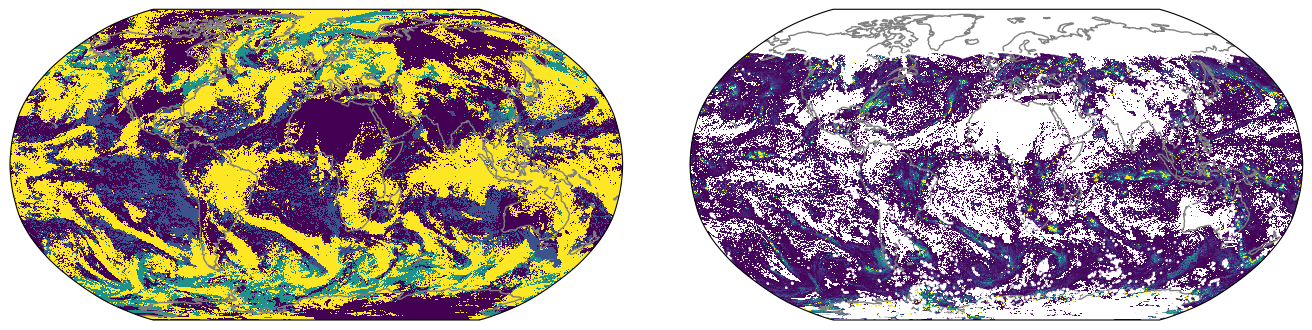

In [23]:
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec

crs = ccrs.Robinson()

fig = plt.figure(figsize=(20, 5))
gs = GridSpec(1, 4, width_ratios=[0.1, 1.0, 1.0, 0.1])

# Cloud phase
ax = fig.add_subplot(gs[0, 1], projection=crs)
lons = patmosx_data.longitude[::4]
lats = patmosx_data.latitude[::4]
ax.pcolormesh(lons, lats, patmosx_data.cloud_phase.data[0, ::4, ::4], transform=ccrs.PlateCarree())
ax.coastlines(color="grey")

# Cloud water path
ax = fig.add_subplot(gs[0, 2], projection=crs)
ax.pcolormesh(lons, lats, patmosx_data.cld_cwp_dcomp.data[0, ::4, ::4], transform=ccrs.PlateCarree())
ax.contour(lons, lats, np.isfinite(patmosx_data.cld_opd_dcomp.data[0, ::4, ::4]), transform=ccrs.PlateCarree(), cmap="Greys")
ax.coastlines(color="grey")

In [80]:
def get_tiwp_patmosx(dataset: xr.Dataset) -> xr.DataArray:
    """
    Determine PATMOS-x TIWP from collocation file.

    Args:
        dataset: A xarray.Dataset containing PATMOS-x/CloudSat collocations.

    Return:
        A DataArray containing the extracted TIWP
    """
    lat_mask = (dataset.latitude > LAT_LIMITS[0]) * (dataset.latitude < LAT_LIMITS[1])
    dataset = dataset[{"rays": lat_mask}]

    tiwp = dataset.cld_iwp_dcomp.data
    return xr.DataArray(
        tiwp,
        dims=("rays",),
        coords = {
            "latitude": (("rays",), dataset.latitude.data),
            "longitude": (("rays"), dataset.longitude.data),
        }
    )

#### MODIS

Just as ISCCP and PATMOS-x, the standard MODIS water path retrievals are also limited to cloudy day-time pixels. For MODIS, however, the ``cloud_phase`` variable can be used to distinguish day-time from night-time results.

A special issue with the MODIS collocations, which are derived from the MOD06-1km-AUX product is that the latitude coordinate does not match those of CloudSat identically and thus the extraction of rays within the latitude bounds leads to inconsistent number of profiles with respect to the CloudSat/CCIC collocations. The ``get_tiwp_modis`` therefore use ``time`` as dimension to allow for interpolating of the data to the CloudSat/CCIC collocations.

In [7]:
def get_tiwp_modis(dataset: xr.Dataset) -> xr.DataArray:
    """
    Determine MODIS TIWP from collocations file.

    Args:
        dataset: A xarray.Dataset containing MODIS collocations.

    Return:
        A DataArray containing the extracted TIWP
    """
    dataset = dataset[{"modis_pixels": 7}]
    valid_rays = (LAT_LIMITS[0] < dataset.latitude.data) * (dataset.latitude.data < LAT_LIMITS[1])
    dataset = dataset[{"rays": valid_rays}]
    
    valid = np.concatenate([[True], np.diff(dataset.time.data) > np.timedelta64(0, "ns")], 0)
    dataset = dataset[{"rays": valid}]
                           
    cloud_phase = dataset.cloud_phase
    cloud_water_path = dataset.cloud_water_path
    # Mask values with undertermined cloud phase.
    ice_mask = cloud_phase.data == 3
    tiwp = np.zeros(dataset.rays.size, dtype="float32")
    tiwp[ice_mask] = dataset.cloud_water_path.data[ice_mask] / 1e3
    tiwp[tiwp < 0] = np.nan
    tiwp[cloud_phase.data <= 0] = np.nan
    tiwp[cloud_phase.data == 4] = np.nan
    
    return xr.DataArray(
        tiwp,
        dims=("time",),
        coords = {
            "time": (("time",), dataset.time.data),
            "latitude": (("time",), dataset.latitude.data),
            "longitude": (("time"), dataset.longitude.data),
        }
    )

## Combine data

In [82]:
def find_granules(path: Path) -> Dict[int, Path]:
    """
    Compile dictionary mapping granules to filenames.

    Args:
        path: A path object pointing to a directory containing CloudSat collocations.

    Return:
        A dictionary mapping granule number to corresponding collocations files.
    """
    path = Path(path)
    files = sorted(list(path.glob("*.nc")))
    granules = {}
    for path in files:
        granule = int(path.name.split("_")[-1][:-3])
        granules[granule] = path
    return granules


In [145]:
modis_granules = find_granules("/data/ccic/collocations/modis/")
isccp_granules = find_granules("/data/ccic/collocations/isccp")
patmosx_granules = find_granules("/data/ccic/collocations/patmosx")
cloudsat_granules = find_granules("/home/simonpf/sun/cloudsat_hanna/output")
common = set(modis_granules).intersection(isccp_granules).intersection(cloudsat_granules).intersection(patmosx_granules)
granule = list(common)[10]

In [146]:
len(cloudsat_granules)

25669

In [165]:
import logging
from tqdm import tqdm
from pansat.time import to_datetime

LOGGER = logging.getLogger("log")

output_path = Path("/data/ccic/collocations/combined")
output_path.mkdir(exist_ok=True)
for granule in tqdm(sorted(list(common)[-1000:])):
    try:
        cs_data = xr.load_dataset(cloudsat_granules[granule])
        data = cs_data.rename(
            iwp_ccic="tiwp_ccic",
            iwp_2cice="tiwp_2cice",
            iwp_dardar="tiwp_dardar"
        )
        data["tiwp_modis"] = get_tiwp_modis(xr.load_dataset(modis_granules[granule])).interp(time=cs_data.time)
        data["tiwp_isccp"] = get_tiwp_isccp(xr.load_dataset(isccp_granules[granule]))
        data["tiwp_patmosx"] = get_tiwp_patmosx(xr.load_dataset(patmosx_granules[granule]))
        start_time = to_datetime(data.time[0].data)
        time_str = start_time.strftime("%Y%m%d%H%M%S")
        filename = f"cloudsat_collocations_{time_str}_{granule}.nc"
        data.to_netcdf(output_path / filename)
    except Exception:
        print(cs_data)
        LOGGER.exception(f"Encountered error processing granule {granule}.")

  0%|                                                                | 0/1000 [00:00<?, ?it/s]log (ERROR     ) :: Encountered error processing granule 56591.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56592.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -2.331 -2.334 -2.336 ... -27.05 -27.05
    latitude           (rays) float32 -0.006167 -0.01584 ... 0.01018 0.0005064
    time               (rays) datetime64[ns] 2016-12-17T01:55:16.953125 ... 2...
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 ... 0.1537 0.1842 0.1341
    cloud_mask_ccic    (rays) float32 0.004 0.004 0.004 0.004 ... 1.0 1.0 1.0
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.002392 0.0 0.0 ... 0.5455 0.5526 0.5526
Attributes:
    cloudsat_granule:    56591
    cloudsat_timestamp:  2016352015516
<xarray.Dataset>
Dimensions:            (rays: 29265)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29260 29

log (ERROR     ) :: Encountered error processing granule 56595.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56596.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 -101.2 -101.2 -101.2 ... -125.9 -125.9
    latitude           (rays) float32 -0.007751 -0.01742 ... 0.01682 0.007153
    time               (rays) datetime64[ns] 2016-12-17T08:30:49.556640625 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.14 0.14 0.14 0.052 ... 0.816 0.816 0.816
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.02632 0.06459 ... 0.05981 0.05981
Attributes:
    cloudsat_granule:    56595
    cloudsat_timestamp:  2016352083049
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 2

log (ERROR     ) :: Encountered error processing granule 56599.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56600.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 159.9 159.9 159.9 ... 135.2 135.2 135.2
    latitude           (rays) float32 -0.002108 -0.01178 ... 0.01457 0.004901
    time               (rays) datetime64[ns] 2016-12-17T15:06:21.871093750 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.002783 0.00265 0.002596 ... 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.116 0.116 0.116 ... 0.152 0.152 0.152
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.09569 0.09569 ... 0.004785 0.004785
Attributes:
    cloudsat_granule:    56599
    cloudsat_timestamp:  2016352150621
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263

log (ERROR     ) :: Encountered error processing granule 56602.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
  1%|▋                                                      | 12/1000 [00:00<01:04, 15.22it/s]log (ERROR     ) :: Encountered error processing granule 56603.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 85.73 85.73 85.73 ... 61.02 61.02 61.02
    latitude           (rays) float32 -0.006254 -0.01592 ... 0.01746 0.007796
    time               (rays) datetime64[ns] 2016-12-17T20:03:01.351562500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 ... 0.02542 0.01195 0.001636
    cloud_mask_ccic    (rays) float32 0.036 0.036 0.036 ... 0.208 0.208 0.208
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.007177 0.0 0.0 ... 0.1627 0.1794 0.1268
Attributes:
    cloudsat_granule:    56602
    cloudsat_timestamp:  2016352200301
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29

log (ERROR     ) :: Encountered error processing granule 56605.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56606.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 11.57 11.57 11.57 ... -13.14 -13.15 -13.15
    latitude           (rays) float32 -0.00447 -0.01414 ... 0.0139 0.004232
    time               (rays) datetime64[ns] 2016-12-18T00:59:40.802001953 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.009829 0.01483 ... 0.002431 0.005904
    cloud_mask_ccic    (rays) float32 0.924 0.924 0.924 0.924 ... 0.14 0.14 0.14
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.216 0.2282 0.3107 ... 0.0311 0.04785
Attributes:
    cloudsat_granule:    56605
    cloudsat_timestamp:  2016353005940
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 292

log (ERROR     ) :: Encountered error processing granule 56609.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56610.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -87.31 -87.32 -87.32 ... -112.0 -112.0
    latitude           (rays) float32 -0.001954 -0.01162 ... 0.01687 0.007199
    time               (rays) datetime64[ns] 2016-12-18T07:35:13.240234375 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.972 0.972 0.972 ... 0.004 0.004 0.004
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.07416 0.07177 ... 0.007177 0.007177
Attributes:
    cloudsat_granule:    56609
    cloudsat_timestamp:  2016353073513
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29

log (ERROR     ) :: Encountered error processing granule 56613.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56614.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29265)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29260 29261 29262 29263 29264
    longitude          (rays) float32 173.8 173.8 173.8 ... 149.1 149.1 149.1
    latitude           (rays) float32 -0.006686 -0.01636 ... 0.0175 0.007828
    time               (rays) datetime64[ns] 2016-12-18T14:10:45.882812500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.002851 0.001954 ... 0.234 0.1687
    cloud_mask_ccic    (rays) float32 0.092 0.092 0.092 0.088 ... 1.0 1.0 1.0
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.1005 0.0933 0.09569 ... 0.5694 0.5718
Attributes:
    cloudsat_granule:    56613
    cloudsat_timestamp:  2016353141045
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263

log (ERROR     ) :: Encountered error processing granule 56616.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
  3%|█▍                                                     | 26/1000 [00:01<01:06, 14.61it/s]log (ERROR     ) :: Encountered error processing granule 56617.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 99.64 99.63 99.63 ... 74.92 74.92 74.92
    latitude           (rays) float32 -0.005278 -0.01495 ... 0.01716 0.007488
    time               (rays) datetime64[ns] 2016-12-18T19:07:25.195312500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.03006 0.03271 0.03057 ... 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 1.0 1.0 1.0 1.0 ... 0.004 0.004 0.004
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.4474 0.5407 0.5335 ... 0.0 0.004785
Attributes:
    cloudsat_granule:    56616
    cloudsat_timestamp:  2016353190725
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 292

log (ERROR     ) :: Encountered error processing granule 56621.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
  3%|█▋                                                     | 30/1000 [00:01<00:59, 16.37it/s]log (ERROR     ) :: Encountered error processing granule 56622.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -23.97 -23.97 -23.97 ... -48.69 -48.69
    latitude           (rays) float32 -0.0056 -0.01527 ... 0.01902 0.009347
    time               (rays) datetime64[ns] 2016-12-19T03:21:50.898437500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.992 0.992 0.992 ... 0.996 0.996 0.996
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.177 0.1675 0.1651 ... 0.3134 0.3134
Attributes:
    cloudsat_granule:    56621
    cloudsat_timestamp:  2016354032150
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29

log (ERROR     ) :: Encountered error processing granule 56626.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
  4%|█▉                                                     | 35/1000 [00:02<00:53, 18.10it/s]log (ERROR     ) :: Encountered error processing granule 56627.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 -147.6 -147.6 -147.6 ... -172.3 -172.3
    latitude           (rays) float32 -0.008429 -0.0181 ... 0.01735 0.007676
    time               (rays) datetime64[ns] 2016-12-19T11:36:16.761718750 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0001081 0.000192
    cloud_mask_ccic    (rays) float32 0.276 0.276 0.276 ... 0.008 0.008 0.008
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.06459 0.06459 ... 0.02871 0.03349
Attributes:
    cloudsat_granule:    56626
    cloudsat_timestamp:  2016354113616
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29

log (ERROR     ) :: Encountered error processing granule 56630.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
  4%|██▏                                                    | 39/1000 [00:02<00:52, 18.40it/s]log (ERROR     ) :: Encountered error processing granule 56631.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 113.5 113.5 113.5 ... 88.82 88.82 88.82
    latitude           (rays) float32 -0.004678 -0.01435 ... 0.01586 0.006191
    time               (rays) datetime64[ns] 2016-12-19T18:11:49.042968750 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.1442 0.1681 0.1821 ... 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.996 0.996 0.996 ... 0.236 0.236 0.236
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.6594 0.6594 0.6594 ... 0.02871 0.007177
Attributes:
    cloudsat_granule:    56630
    cloudsat_timestamp:  2016354181149
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 

log (ERROR     ) :: Encountered error processing granule 56634.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
  4%|██▎                                                    | 43/1000 [00:02<00:55, 17.22it/s]log (ERROR     ) :: Encountered error processing granule 56635.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 14.65 14.65 14.65 ... -10.06 -10.06 -10.07
    latitude           (rays) float32 -0.001677 -0.01135 ... 0.01691 0.007243
    time               (rays) datetime64[ns] 2016-12-20T00:47:21.618896484 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.01039 0.01118 0.01441 ... 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.116 0.116 0.116 0.116 ... 0.06 0.06 0.06
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.1265 0.1217 0.1217 ... 0.06459 0.07177
Attributes:
    cloudsat_granule:    56634
    cloudsat_timestamp:  2016355004721
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29

log (ERROR     ) :: Encountered error processing granule 56638.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
  5%|██▌                                                    | 47/1000 [00:02<00:58, 16.24it/s]log (ERROR     ) :: Encountered error processing granule 56639.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -84.23 -84.23 -84.24 ... -109.0 -109.0
    latitude           (rays) float32 -0.00347 -0.01314 ... 0.01534 0.005669
    time               (rays) datetime64[ns] 2016-12-20T07:22:54.097656250 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.572 0.572 0.572 ... 0.164 0.164 0.164
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.03828 0.09809 ... 0.01196 0.05742
Attributes:
    cloudsat_granule:    56638
    cloudsat_timestamp:  2016355072254
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264

log (ERROR     ) :: Encountered error processing granule 56641.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56642.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -158.4 -158.4 -158.4 ... 176.9 176.9 176.9
    latitude           (rays) float32 -8.738e-05 -0.009757 ... 0.01428 0.004606
    time               (rays) datetime64[ns] 2016-12-20T12:19:33.570312500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 ... 0.0004295 0.0003457
    cloud_mask_ccic    (rays) float32 0.656 0.656 0.656 ... 0.012 0.012 0.012
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.01435 0.01435 ... 0.02153 0.03349
Attributes:
    cloudsat_granule:    56641
    cloudsat_timestamp:  2016355121933
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29

  5%|██▉                                                    | 53/1000 [00:03<01:02, 15.06it/s]log (ERROR     ) :: Encountered error processing granule 56645.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56646.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 102.7 102.7 102.7 ... 78.01 78.0 78.0
    latitude           (rays) float32 -0.004223 -0.01389 ... 0.01786 0.00819
    time               (rays) datetime64[ns] 2016-12-20T18:55:05.992187500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.1846 0.2152 ... 0.0006184 0.0005285
    cloud_mask_ccic    (rays) float32 0.996 0.996 0.996 ... 0.176 0.176 0.176
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.5899 0.5899 0.5875 ... 0.03828 0.03349
Attributes:
    cloudsat_granule:    56645
    cloudsat_timestamp:  2016355185505
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 292

log (ERROR     ) :: Encountered error processing granule 56648.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
  6%|███▏                                                   | 57/1000 [00:03<01:06, 14.23it/s]log (ERROR     ) :: Encountered error processing granule 56649.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 28.56 28.55 28.55 ... 3.84 3.838 3.836
    latitude           (rays) float32 -0.005085 -0.01475 ... 0.01409 0.00442
    time               (rays) datetime64[ns] 2016-12-20T23:51:45.500000 ... 2...
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.04717 0.02019 ... 0.0008993 0.0009088
    cloud_mask_ccic    (rays) float32 0.24 0.24 0.24 0.24 ... 0.128 0.128 0.128
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.2338 0.2289 0.4552 ... 0.02153 0.02153
Attributes:
    cloudsat_granule:    56648
    cloudsat_timestamp:  2016355235145
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 2926

log (ERROR     ) :: Encountered error processing granule 56651.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56652.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 -45.61 -45.61 -45.61 ... -70.33 -70.33
    latitude           (rays) float32 -0.009487 -0.01916 ... 0.011 0.001333
    time               (rays) datetime64[ns] 2016-12-21T04:48:24.816406250 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.005164 0.004909 ... 0.0004304 0.0003421
    cloud_mask_ccic    (rays) float32 0.684 0.684 0.684 ... 0.304 0.304 0.304
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.2416 0.2344 0.2416 ... 0.1446 0.1446
Attributes:
    cloudsat_granule:    56651
    cloudsat_timestamp:  2016356044824
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 2

log (ERROR     ) :: Encountered error processing granule 56654.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
  6%|███▍                                                   | 63/1000 [00:03<01:07, 13.80it/s]log (ERROR     ) :: Encountered error processing granule 56655.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -119.8 -119.8 -119.8 ... -144.5 -144.5
    latitude           (rays) float32 -0.00224 -0.01191 ... 0.01775 0.008078
    time               (rays) datetime64[ns] 2016-12-21T09:45:04.328125 ... 2...
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.528 0.528 0.528 ... 0.008 0.008 0.008
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.05742 0.05502 0.05502 ... 0.0 0.0 0.0
Attributes:
    cloudsat_granule:    56654
    cloudsat_timestamp:  2016356094504
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 2

log (ERROR     ) :: Encountered error processing granule 56657.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56658.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29265)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29260 29261 29262 29263 29264
    longitude          (rays) float32 166.1 166.1 166.1 ... 141.3 141.3 141.3
    latitude           (rays) float32 -0.007009 -0.01668 ... 0.01777 0.008101
    time               (rays) datetime64[ns] 2016-12-21T14:41:43.644531250 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.007302 0.00625 ... 0.0002692 0.0001911
    cloud_mask_ccic    (rays) float32 0.116 0.116 0.116 ... 0.852 0.852 0.852
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.134 0.134 0.1316 ... 0.3565 0.2703
Attributes:
    cloudsat_granule:    56657
    cloudsat_timestamp:  2016356144143
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 2

log (ERROR     ) :: Encountered error processing granule 56661.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56662.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29268)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29263 29264 29265 29266 29267
    longitude          (rays) float32 67.18 67.18 67.18 ... 42.46 42.46 42.46
    latitude           (rays) float32 -0.003356 -0.01302 ... 0.01011 0.0004409
    time               (rays) datetime64[ns] 2016-12-21T21:17:16.125000 ... 2...
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.024 0.024 0.024 ... 0.004 0.004 0.004
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.0 0.002392 0.004785 ... 0.0 0.0 0.0
Attributes:
    cloudsat_granule:    56661
    cloudsat_timestamp:  2016356211716
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 

log (ERROR     ) :: Encountered error processing granule 56665.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56666.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29265)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29260 29261 29262 29263 29264
    longitude          (rays) float32 -31.71 -31.71 -31.71 ... -56.42 -56.42
    latitude           (rays) float32 -0.007199 -0.01687 ... 0.01848 0.008806
    time               (rays) datetime64[ns] 2016-12-22T03:52:48.659179687 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.05001 0.2307 ... 0.01326 0.009522
    cloud_mask_ccic    (rays) float32 0.996 0.996 0.996 ... 0.304 0.304 0.304
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.244 0.2416 0.5526 ... 0.2222 0.2349
Attributes:
    cloudsat_granule:    56665
    cloudsat_timestamp:  2016357035248
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 

log (ERROR     ) :: Encountered error processing granule 56669.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56670.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -130.6 -130.6 -130.6 ... -155.3 -155.3
    latitude           (rays) float32 -0.003487 -0.01316 ... 0.01437 0.0047
    time               (rays) datetime64[ns] 2016-12-22T10:28:21.296875 ... 2...
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 ... 0.000508 0.0004322
    cloud_mask_ccic    (rays) float32 0.0 0.0 0.0 0.0 ... 0.024 0.024 0.024
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.0 0.0 0.0 0.0 ... 0.03349 0.0311 0.0311
Attributes:
    cloudsat_granule:    56669
    cloudsat_timestamp:  2016357102821
<xarray.Dataset>
Dimensions:            (rays: 29268)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29263 29264 29265 2

log (ERROR     ) :: Encountered error processing granule 56673.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
  8%|████▍                                                  | 81/1000 [00:05<01:01, 15.04it/s]log (ERROR     ) :: Encountered error processing granule 56687.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 144.4 144.4 144.4 ... 119.7 119.7 119.7
    latitude           (rays) float32 -0.009295 -0.01896 ... 0.01275 0.003077
    time               (rays) datetime64[ns] 2016-12-23T16:08:17.445312500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.00121 0.001768 ... 0.01675 0.01932
    cloud_mask_ccic    (rays) float32 0.908 0.908 0.908 ... 0.96 0.96 0.936
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.05742 0.06938 0.06938 ... 0.2374 0.2398
Attributes:
    cloudsat_granule:    56687
    cloudsat_timestamp:  2016358160817
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29

log (ERROR     ) :: Encountered error processing granule 56691.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56692.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 45.54 45.54 45.54 ... 20.82 20.82 20.82
    latitude           (rays) float32 -0.008703 -0.01837 ... 0.01091 0.001243
    time               (rays) datetime64[ns] 2016-12-23T22:43:50.085937500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 ... 0.04584 0.1725 0.209
    cloud_mask_ccic    (rays) float32 0.004 0.004 0.004 ... 0.992 0.992 0.992
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.007177 0.004785 0.009569 ... 0.562 0.562
Attributes:
    cloudsat_granule:    56691
    cloudsat_timestamp:  2016358224350
<xarray.Dataset>
Dimensions:            (rays: 29268)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29263 2

log (ERROR     ) :: Encountered error processing granule 56694.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
  9%|████▉                                                  | 89/1000 [00:05<01:07, 13.42it/s]log (ERROR     ) :: Encountered error processing granule 56695.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -28.62 -28.63 -28.63 ... -53.34 -53.34
    latitude           (rays) float32 -0.0001406 -0.00981 ... 0.01502 0.005352
    time               (rays) datetime64[ns] 2016-12-24T03:40:29.241210937 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0001334 0.0002301 ... 0.01029 0.01025
    cloud_mask_ccic    (rays) float32 0.052 0.032 0.032 0.032 ... 0.92 0.92 0.92
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.02871 0.02153 0.02871 ... 0.3133 0.3229
Attributes:
    cloudsat_granule:    56694
    cloudsat_timestamp:  2016359034029
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 

log (ERROR     ) :: Encountered error processing granule 56697.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56698.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 -127.5 -127.5 -127.5 ... -152.2 -152.2
    latitude           (rays) float32 -0.007288 -0.01696 ... 0.01086 0.001188
    time               (rays) datetime64[ns] 2016-12-24T10:16:02.039062500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.0 0.0 0.0 0.0 ... 0.244 0.244 0.244
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.0 0.0 0.0 ... 0.06699 0.009569 0.007177
Attributes:
    cloudsat_granule:    56698
    cloudsat_timestamp:  2016359101602
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 

log (ERROR     ) :: Encountered error processing granule 56702.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 10%|█████▎                                                 | 97/1000 [00:06<00:59, 15.06it/s]log (ERROR     ) :: Encountered error processing granule 56703.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 133.6 133.6 133.6 ... 108.9 108.9 108.9
    latitude           (rays) float32 -0.008426 -0.0181 ... 0.0139 0.004233
    time               (rays) datetime64[ns] 2016-12-24T16:51:34.300781250 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0003085 0.0003521 ... 0.01022 0.01451
    cloud_mask_ccic    (rays) float32 0.496 0.496 0.496 ... 0.908 0.908 0.908
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.04545 0.03828 0.04306 ... 0.2775 0.2847
Attributes:
    cloudsat_granule:    56702
    cloudsat_timestamp:  2016359165134
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263

log (ERROR     ) :: Encountered error processing granule 56713.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56714.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -138.3 -138.3 -138.3 ... -163.0 -163.0
    latitude           (rays) float32 -0.00244 -0.01211 ... 0.01443 0.004762
    time               (rays) datetime64[ns] 2016-12-25T10:59:18.832031250 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.396 0.396 0.396 ... 0.008 0.008 0.008
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.01196 0.007177 0.02632 ... 0.0 0.01675
Attributes:
    cloudsat_granule:    56713
    cloudsat_timestamp:  2016360105918
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 

log (ERROR     ) :: Encountered error processing granule 56717.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56718.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 122.8 122.8 122.8 ... 98.07 98.07 98.07
    latitude           (rays) float32 -0.004228 -0.0139 ... 0.01622 0.006553
    time               (rays) datetime64[ns] 2016-12-25T17:34:51.152343750 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.002568 0.003322 ... 0.08207 0.0934
    cloud_mask_ccic    (rays) float32 0.728 0.64 0.64 0.64 ... 0.988 0.988 0.988
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.08373 0.08612 0.0933 ... 0.6531 0.6507
Attributes:
    cloudsat_granule:    56717
    cloudsat_timestamp:  2016360173451
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262

log (ERROR     ) :: Encountered error processing granule 56722.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 11%|█████▉                                                | 109/1000 [00:07<00:50, 17.59it/s]log (ERROR     ) :: Encountered error processing granule 56723.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -0.8197 -0.8217 -0.8238 ... -25.54 -25.54
    latitude           (rays) float32 -0.003029 -0.0127 ... 0.01283 0.003164
    time               (rays) datetime64[ns] 2016-12-26T01:49:16.856933593 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0009273 0.0007627 0.0007019 ... 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.992 0.992 0.992 ... 0.024 0.024 0.024
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.3278 0.3206 0.3349 ... 0.004785 0.004785
Attributes:
    cloudsat_granule:    56722
    cloudsat_timestamp:  2016361014916
<xarray.Dataset>
Dimensions:            (rays: 29265)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29260

log (ERROR     ) :: Encountered error processing granule 56725.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56726.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -74.98 -74.99 -74.99 ... -99.7 -99.7 -99.7
    latitude           (rays) float32 -0.006217 -0.01589 ... 0.01192 0.002253
    time               (rays) datetime64[ns] 2016-12-26T06:45:56.171875 ... 2...
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.09522 0.1109 0.1446 ... 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.964 0.964 0.964 ... 0.028 0.028 0.028
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.5097 0.5628 0.5628 ... 0.01435 0.002392
Attributes:
    cloudsat_granule:    56725
    cloudsat_timestamp:  2016361064556
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29

log (ERROR     ) :: Encountered error processing granule 56728.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 12%|██████▏                                               | 115/1000 [00:07<01:03, 13.91it/s]log (ERROR     ) :: Encountered error processing granule 56729.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -149.1 -149.2 -149.2 ... -173.9 -173.9
    latitude           (rays) float32 -0.002729 -0.0124 ... 0.01249 0.002823
    time               (rays) datetime64[ns] 2016-12-26T11:42:35.687500 ... 2...
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.004 0.004 0.004 0.004 ... 0.0 0.0 0.0
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.009569 0.007177 0.009569 ... 0.0 0.0 0.0
Attributes:
    cloudsat_granule:    56728
    cloudsat_timestamp:  2016361114235
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 2926

log (ERROR     ) :: Encountered error processing granule 56731.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56740.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 136.7 136.7 136.7 ... 112.0 112.0 112.0
    latitude           (rays) float32 -0.006501 -0.01617 ... 0.01593 0.006261
    time               (rays) datetime64[ns] 2016-12-26T16:39:14.882812500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0001386 0.0002575 ... 0.1113 0.1301
    cloud_mask_ccic    (rays) float32 0.008 0.008 0.008 ... 0.996 0.996 0.996
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.01196 0.01675 0.01675 ... 0.6451 0.6451
Attributes:
    cloudsat_granule:    56731
    cloudsat_timestamp:  2016361163914
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263

log (ERROR     ) :: Encountered error processing granule 56742.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 12%|██████▌                                               | 121/1000 [00:08<01:14, 11.77it/s]log (ERROR     ) :: Encountered error processing granule 56743.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -135.2 -135.2 -135.3 ... -160.0 -160.0
    latitude           (rays) float32 -0.002364 -0.01203 ... 0.01468 0.005015
    time               (rays) datetime64[ns] 2016-12-27T10:46:59.414062500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.002392 0.007177 0.004785 ... 0.0 0.0 0.0
Attributes:
    cloudsat_granule:    56742
    cloudsat_timestamp:  2016362104659
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 292

log (ERROR     ) :: Encountered error processing granule 56745.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56746.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 150.6 150.6 150.6 ... 125.9 125.9 125.9
    latitude           (rays) float32 -0.005899 -0.01557 ... 0.01359 0.003915
    time               (rays) datetime64[ns] 2016-12-27T15:43:38.609375 ... 2...
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 ... 0.01684 0.01562 0.01602
    cloud_mask_ccic    (rays) float32 0.032 0.032 0.032 ... 0.836 0.836 0.836
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.0 0.0 0.0 0.0 ... 0.3134 0.323 0.3134
Attributes:
    cloudsat_granule:    56745
    cloudsat_timestamp:  2016362154338
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263

log (ERROR     ) :: Encountered error processing granule 56748.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 13%|██████▊                                               | 127/1000 [00:08<01:07, 12.95it/s]log (ERROR     ) :: Encountered error processing granule 56749.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 76.43 76.43 76.42 ... 51.71 51.71 51.71
    latitude           (rays) float32 -0.001361 -0.01103 ... 0.01199 0.002326
    time               (rays) datetime64[ns] 2016-12-27T20:40:17.960937500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0009705 0.00146 ... 0.00135 0.001114
    cloud_mask_ccic    (rays) float32 0.356 0.356 0.356 ... 0.068 0.068 0.068
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.02871 0.02632 ... 0.05502 0.05502
Attributes:
    cloudsat_granule:    56748
    cloudsat_timestamp:  2016362204017
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 2926

log (ERROR     ) :: Encountered error processing granule 56751.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56752.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 2.263 2.261 2.259 ... -22.45 -22.45 -22.46
    latitude           (rays) float32 -0.004503 -0.01417 ... 0.01167 0.002003
    time               (rays) datetime64[ns] 2016-12-28T01:36:57.437011718 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.000342 0.0006546 0.0003244 ... 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.36 0.36 0.36 0.36 ... 0.008 0.008 0.008
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.2871 0.2895 0.2823 ... 0.002392 0.0
Attributes:
    cloudsat_granule:    56751
    cloudsat_timestamp:  2016363013657
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 2

log (ERROR     ) :: Encountered error processing granule 56754.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 13%|███████▏                                              | 133/1000 [00:09<01:12, 11.97it/s]log (ERROR     ) :: Encountered error processing granule 56755.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -71.9 -71.9 -71.9 ... -96.62 -96.62 -96.62
    latitude           (rays) float32 -0.001581 -0.01125 ... 0.01606 0.006386
    time               (rays) datetime64[ns] 2016-12-28T06:33:36.630859375 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.008445 0.0118 0.01098 ... 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.988 0.988 0.988 ... 0.472 0.472 0.472
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.294 0.4988 0.3084 ... 0.05024 0.05024
Attributes:
    cloudsat_granule:    56754
    cloudsat_timestamp:  2016363063336
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29

log (ERROR     ) :: Encountered error processing granule 56757.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56758.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 -146.1 -146.1 -146.1 ... -170.8 -170.8
    latitude           (rays) float32 -0.006693 -0.01636 ... 0.01862 0.008954
    time               (rays) datetime64[ns] 2016-12-28T11:30:16.304687500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.664 0.664 0.664 0.528 ... 0.0 0.0 0.0
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.06459 0.06459 0.0622 ... 0.0 0.0 0.0
Attributes:
    cloudsat_granule:    56757
    cloudsat_timestamp:  2016363113016
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 2

log (ERROR     ) :: Encountered error processing granule 56760.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 14%|███████▌                                              | 139/1000 [00:09<01:10, 12.13it/s]log (ERROR     ) :: Encountered error processing granule 56761.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 139.8 139.8 139.8 ... 115.1 115.1 115.1
    latitude           (rays) float32 -0.008267 -0.01794 ... 0.01405 0.004376
    time               (rays) datetime64[ns] 2016-12-28T16:26:55.460937500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.01426 0.01451 0.01364 ... 0.1143 0.1094
    cloud_mask_ccic    (rays) float32 0.116 0.116 0.116 ... 0.996 0.996 0.996
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.1435 0.1507 0.1507 ... 0.6434 0.6386
Attributes:
    cloudsat_granule:    56760
    cloudsat_timestamp:  2016363162655
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 2926

log (ERROR     ) :: Encountered error processing granule 56763.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56764.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29268)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29263 29264 29265 29266 29267
    longitude          (rays) float32 65.61 65.61 65.61 ... 40.89 40.89 40.89
    latitude           (rays) float32 -0.001249 -0.01092 ... 0.01152 0.001853
    time               (rays) datetime64[ns] 2016-12-28T21:23:34.812500 ... 2...
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.002897 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.656 0.656 0.656 ... 0.404 0.404 0.404
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.04306 0.1316 0.04785 ... 0.1947 0.1947
Attributes:
    cloudsat_granule:    56763
    cloudsat_timestamp:  2016363212334
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 292

log (ERROR     ) :: Encountered error processing granule 56766.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 14%|███████▊                                              | 145/1000 [00:10<01:16, 11.23it/s]log (ERROR     ) :: Encountered error processing granule 56767.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 -8.556 -8.559 -8.561 ... -33.27 -33.27
    latitude           (rays) float32 -0.009195 -0.01886 ... 0.01532 0.005653
    time               (rays) datetime64[ns] 2016-12-29T02:20:14.329101562 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.001758 0.001453 0.001275 ... 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.08 0.08 0.08 0.088 ... 0.104 0.104 0.104
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.1364 0.08373 0.08852 ... 0.0 0.0 0.0
Attributes:
    cloudsat_granule:    56766
    cloudsat_timestamp:  2016364022014
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 2

log (ERROR     ) :: Encountered error processing granule 56769.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56770.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -82.72 -82.72 -82.72 ... -107.4 -107.4
    latitude           (rays) float32 -0.00059 -0.01026 ... 0.01761 0.007945
    time               (rays) datetime64[ns] 2016-12-29T07:16:53.484375 ... 2...
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.832 0.832 0.832 ... 0.668 0.668 0.668
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.009569 0.01196 ... 0.05742 0.05742
Attributes:
    cloudsat_granule:    56769
    cloudsat_timestamp:  2016364071653
<xarray.Dataset>
Dimensions:            (rays: 29268)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29263 29264 2926

log (ERROR     ) :: Encountered error processing granule 56772.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 15%|████████▏                                             | 151/1000 [00:10<01:15, 11.22it/s]log (ERROR     ) :: Encountered error processing granule 56773.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -156.9 -156.9 -156.9 ... 178.4 178.4 178.4
    latitude           (rays) float32 -0.001278 -0.01095 ... 0.01246 0.00279
    time               (rays) datetime64[ns] 2016-12-29T12:13:33 ... 2016-12-...
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.0 0.0 0.0 0.0 ... 0.08 0.08 0.08 0.08
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    cloudsat_granule:    56772
    cloudsat_timestamp:  2016364121333
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 292

log (ERROR     ) :: Encountered error processing granule 56775.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56776.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 129.0 129.0 128.9 ... 104.2 104.2 104.2
    latitude           (rays) float32 -0.004409 -0.01408 ... 0.01709 0.007419
    time               (rays) datetime64[ns] 2016-12-29T17:10:12.195312500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0968 0.02036 0.1013 ... 0.01101 0.01081
    cloud_mask_ccic    (rays) float32 0.996 0.996 0.996 ... 0.936 0.936 0.908
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.512 0.4761 0.5144 ... 0.4402 0.4426
Attributes:
    cloudsat_granule:    56775
    cloudsat_timestamp:  2016364171012
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263

log (ERROR     ) :: Encountered error processing granule 56777.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56778.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 54.79 54.79 54.79 ... 30.08 30.07 30.07
    latitude           (rays) float32 -0.006026 -0.0157 ... 0.01432 0.004652
    time               (rays) datetime64[ns] 2016-12-29T22:06:51.710937500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 ... 0.002779 0.003199 0.003465
    cloud_mask_ccic    (rays) float32 0.076 0.076 0.076 ... 0.064 0.064 0.064
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.004785 0.002392 ... 0.1119 0.3209
Attributes:
    cloudsat_granule:    56778
    cloudsat_timestamp:  2016364220651
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 2

log (ERROR     ) :: Encountered error processing granule 56781.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56782.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -19.37 -19.38 -19.38 ... -44.09 -44.09
    latitude           (rays) float32 -0.002248 -0.01192 ... 0.01189 0.002221
    time               (rays) datetime64[ns] 2016-12-30T03:03:30.962890625 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.012 0.012 0.012 ... 0.104 0.104 0.104
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.004785 0.009569 0.0 ... 0.2536 0.2464
Attributes:
    cloudsat_granule:    56781
    cloudsat_timestamp:  2016365030330
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 

log (ERROR     ) :: Encountered error processing granule 56784.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 16%|████████▊                                             | 163/1000 [00:11<01:13, 11.42it/s]log (ERROR     ) :: Encountered error processing granule 56785.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 -93.54 -93.54 -93.54 ... -118.3 -118.3
    latitude           (rays) float32 -0.009644 -0.01931 ... 0.01679 0.007116
    time               (rays) datetime64[ns] 2016-12-30T08:00:10.476562500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.032 0.032 0.032 0.044 ... 0.54 0.54 0.54
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.03349 0.02871 0.0311 ... 0.08134 0.08134
Attributes:
    cloudsat_granule:    56784
    cloudsat_timestamp:  2016365080010
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 

log (ERROR     ) :: Encountered error processing granule 56787.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56788.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 -167.7 -167.7 -167.7 ... 167.6 167.6 167.6
    latitude           (rays) float32 -0.005355 -0.01503 ... 0.01791 0.008239
    time               (rays) datetime64[ns] 2016-12-30T12:56:49.832031250 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 ... 0.006482 0.006487 0.006584
    cloud_mask_ccic    (rays) float32 0.052 0.052 0.052 ... 0.008 0.008 0.008
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.0 0.0 0.0 0.0 ... 0.1148 0.1172 0.1172
Attributes:
    cloudsat_granule:    56787
    cloudsat_timestamp:  2016365125649
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 2926

log (ERROR     ) :: Encountered error processing granule 56810.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 17%|█████████▏                                            | 169/1000 [00:12<01:12, 11.44it/s]log (ERROR     ) :: Encountered error processing granule 56811.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -16.29 -16.29 -16.29 ... -41.01 -41.01
    latitude           (rays) float32 -0.002606 -0.01228 ... 0.0116 0.001932
    time               (rays) datetime64[ns] 2017-01-01T02:51:10.410156250 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0003453 0.0003558 0.0005153 ... 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.036 0.036 0.036 ... 0.012 0.012 0.012
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.05502 0.0622 0.05981 ... 0.0 0.007177
Attributes:
    cloudsat_granule:    56810
    cloudsat_timestamp:  2017001025110
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263

log (ERROR     ) :: Encountered error processing granule 56813.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56814.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -90.45 -90.45 -90.46 ... -115.2 -115.2
    latitude           (rays) float32 -0.002318 -0.01199 ... 0.01513 0.005458
    time               (rays) datetime64[ns] 2017-01-01T07:47:49.763671875 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.0 0.0 0.0 0.0 ... 0.036 0.036 0.036
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.002392 0.004785 ... 0.06938 0.06938
Attributes:
    cloudsat_granule:    56813
    cloudsat_timestamp:  2017001074749
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 2926

log (ERROR     ) :: Encountered error processing granule 56816.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 18%|█████████▍                                            | 175/1000 [00:12<01:12, 11.44it/s]log (ERROR     ) :: Encountered error processing granule 56817.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29268)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29263 29264 29265 29266 29267
    longitude          (rays) float32 -164.6 -164.6 -164.6 ... 170.7 170.7 170.7
    latitude           (rays) float32 -0.003799 -0.01347 ... 0.009776 0.0001059
    time               (rays) datetime64[ns] 2017-01-01T12:44:29.238281250 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0016 0.00147 ... 0.02328 0.03135
    cloud_mask_ccic    (rays) float32 0.04 0.04 0.04 0.04 ... 0.996 0.996 0.996
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.0622 0.06459 0.06938 ... 0.2201 0.2129
Attributes:
    cloudsat_granule:    56816
    cloudsat_timestamp:  2017001124429
<xarray.Dataset>
Dimensions:            (rays: 29268)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29263 29

log (ERROR     ) :: Encountered error processing granule 56820.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 18%|█████████▋                                            | 179/1000 [00:12<00:59, 13.70it/s]log (ERROR     ) :: Encountered error processing granule 56821.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 96.5 96.5 96.49 ... 71.78 71.78 71.78
    latitude           (rays) float32 -0.003422 -0.01309 ... 0.01823 0.008564
    time               (rays) datetime64[ns] 2017-01-01T19:20:01.554687500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.01889 0.01921 0.0156 ... 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.16 0.16 0.16 0.16 ... 0.364 0.4 0.4 0.4
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.2225 0.2344 0.1627 ... 0.3014 0.3014
Attributes:
    cloudsat_granule:    56820
    cloudsat_timestamp:  2017001192001
<xarray.Dataset>
Dimensions:            (rays: 29268)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29263 29264 2

log (ERROR     ) :: Encountered error processing granule 56824.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 18%|█████████▉                                            | 183/1000 [00:13<00:53, 15.30it/s]log (ERROR     ) :: Encountered error processing granule 56825.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -2.387 -2.389 -2.391 ... -27.1 -27.11
    latitude           (rays) float32 -0.007343 -0.01701 ... 0.01755 0.007883
    time               (rays) datetime64[ns] 2017-01-02T01:55:34.173828125 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.072 0.072 0.072 ... 0.424 0.424 0.424
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.1268 0.1172 0.1172 ... 0.08134 0.07895
Attributes:
    cloudsat_granule:    56824
    cloudsat_timestamp:  2017002015534
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 

log (ERROR     ) :: Encountered error processing granule 56827.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56828.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -76.55 -76.55 -76.55 ... -101.3 -101.3
    latitude           (rays) float32 -0.001647 -0.01132 ... 0.01618 0.006505
    time               (rays) datetime64[ns] 2017-01-02T06:52:13.328125 ... 2...
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.3958 0.3092 0.3232 ... 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.588 0.588 0.588 ... 0.532 0.532 0.532
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.2252 0.2228 0.2203 ... 0.05981 0.05981
Attributes:
    cloudsat_granule:    56827
    cloudsat_timestamp:  2017002065213
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29

log (ERROR     ) :: Encountered error processing granule 56830.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 19%|██████████▏                                           | 189/1000 [00:13<01:04, 12.59it/s]log (ERROR     ) :: Encountered error processing granule 56831.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -150.7 -150.7 -150.7 ... -175.4 -175.4
    latitude           (rays) float32 -0.0003032 -0.009973 ... 0.01411 0.004444
    time               (rays) datetime64[ns] 2017-01-02T11:48:52.843750 ... 2...
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 ... 0.0001863 0.0002734
    cloud_mask_ccic    (rays) float32 0.004 0.004 0.004 ... 0.052 0.052 0.052
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.0 0.0 0.0 ... 0.02632 0.02632 0.02871
Attributes:
    cloudsat_granule:    56830
    cloudsat_timestamp:  2017002114852
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29

log (ERROR     ) :: Encountered error processing granule 56834.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56837.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 110.4 110.4 110.4 ... 85.69 85.69 85.68
    latitude           (rays) float32 -0.003142 -0.01281 ... 0.01689 0.007219
    time               (rays) datetime64[ns] 2017-01-02T18:24:25.164062500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.1601 0.09672 0.09837 ... 0.02183 0.02903
    cloud_mask_ccic    (rays) float32 0.996 0.996 0.996 ... 0.744 0.744 0.684
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.6859 0.6859 0.6811 ... 0.3421 0.3469
Attributes:
    cloudsat_granule:    56834
    cloudsat_timestamp:  2017002182425
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 292

log (ERROR     ) :: Encountered error processing granule 56840.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56841.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -37.93 -37.93 -37.93 ... -62.64 -62.65
    latitude           (rays) float32 -0.004914 -0.01458 ... 0.01206 0.002394
    time               (rays) datetime64[ns] 2017-01-03T04:17:43.869140625 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.1675 0.02499 ... 0.004703 0.002767
    cloud_mask_ccic    (rays) float32 0.996 0.996 0.996 0.996 ... 0.78 0.78 0.76
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.4043 0.3947 0.378 ... 0.3141 0.3141
Attributes:
    cloudsat_granule:    56840
    cloudsat_timestamp:  2017003041743
<xarray.Dataset>
Dimensions:            (rays: 29268)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29263 29264 29

log (ERROR     ) :: Encountered error processing granule 56844.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56845.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 -136.8 -136.8 -136.8 ... -161.5 -161.5
    latitude           (rays) float32 -0.008385 -0.01806 ... 0.01771 0.008043
    time               (rays) datetime64[ns] 2017-01-03T10:53:16.605468750 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.0 0.0 0.0 0.0 ... 0.06 0.02 0.02 0.02
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    cloudsat_granule:    56844
    cloudsat_timestamp:  2017003105316
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 

log (ERROR     ) :: Encountered error processing granule 56848.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56849.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 124.3 124.3 124.3 ... 99.59 99.59 99.59
    latitude           (rays) float32 -0.003469 -0.01314 ... 0.01675 0.007078
    time               (rays) datetime64[ns] 2017-01-03T17:28:48.765625 ... 2...
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.02281 0.01919 0.01694 ... 0.1743 0.1191
    cloud_mask_ccic    (rays) float32 0.556 0.556 0.556 0.556 ... 1.0 1.0 1.0
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.2919 0.2943 0.2943 ... 0.6699 0.6675
Attributes:
    cloudsat_granule:    56848
    cloudsat_timestamp:  2017003172848
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 2926

log (ERROR     ) :: Encountered error processing granule 56852.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56853.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 25.42 25.42 25.42 ... 0.7045 0.7025 0.7004
    latitude           (rays) float32 -0.00331 -0.01298 ... 0.01491 0.005238
    time               (rays) datetime64[ns] 2017-01-04T00:04:21.342987060 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.006363 0.008423 ... 0.003334 0.004414
    cloud_mask_ccic    (rays) float32 0.4 0.4 0.4 0.488 ... 0.096 0.096 0.096
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.2024 0.2 0.2024 ... 0.3517 0.3565 0.3541
Attributes:
    cloudsat_granule:    56852
    cloudsat_timestamp:  2017004000421
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 

log (ERROR     ) :: Encountered error processing granule 56856.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56857.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -73.46 -73.47 -73.47 ... -98.18 -98.18
    latitude           (rays) float32 -0.002754 -0.01242 ... 0.01464 0.004973
    time               (rays) datetime64[ns] 2017-01-04T06:39:53.660156250 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.000246 0.0003922 0.0004251 ... 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.408 0.408 0.408 0.408 ... 0.5 0.5 0.5
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.05556 0.2005 0.1957 ... 0.05024 0.05024
Attributes:
    cloudsat_granule:    56856
    cloudsat_timestamp:  2017004063953
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 292

log (ERROR     ) :: Encountered error processing granule 56860.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56861.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -172.4 -172.4 -172.4 ... 162.9 162.9 162.9
    latitude           (rays) float32 -0.003815 -0.01349 ... 0.0188 0.009131
    time               (rays) datetime64[ns] 2017-01-04T13:15:26.277343750 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 ... 0.01999 0.02075 0.01588
    cloud_mask_ccic    (rays) float32 0.004 0.004 0.004 ... 0.948 0.948 0.948
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.0 0.0 0.0 ... 0.2057 0.2129 0.2344
Attributes:
    cloudsat_granule:    56860
    cloudsat_timestamp:  2017004131526
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 

log (ERROR     ) :: Encountered error processing granule 56863.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 22%|███████████▉                                          | 220/1000 [00:15<00:56, 13.90it/s]log (ERROR     ) :: Encountered error processing granule 56864.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 113.5 113.5 113.5 ... 88.77 88.77 88.77
    latitude           (rays) float32 -0.009515 -0.01919 ... 0.009882 0.0002122
    time               (rays) datetime64[ns] 2017-01-04T18:12:05.589843750 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.08487 0.0891 0.1016 ... 0.02916 0.07061
    cloud_mask_ccic    (rays) float32 0.996 0.996 0.996 0.996 ... 0.98 0.98 0.98
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.6126 0.6102 0.6174 ... 0.07656 0.3254
Attributes:
    cloudsat_granule:    56863
    cloudsat_timestamp:  2017004181205
<xarray.Dataset>
Dimensions:            (rays: 29268)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 2926

log (ERROR     ) :: Encountered error processing granule 56866.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56867.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 39.32 39.32 39.32 ... 14.61 14.61 14.6
    latitude           (rays) float32 -0.003668 -0.01334 ... 0.01457 0.004904
    time               (rays) datetime64[ns] 2017-01-04T23:08:44.945312500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.004 0.004 0.004 ... 0.492 0.492 0.492
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.0 0.0 0.0 0.0 ... 0.2537 0.2512 0.2506
Attributes:
    cloudsat_granule:    56866
    cloudsat_timestamp:  2017004230844
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263

log (ERROR     ) :: Encountered error processing granule 56869.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 23%|████████████▏                                         | 226/1000 [00:16<01:01, 12.49it/s]log (ERROR     ) :: Encountered error processing granule 56870.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -34.84 -34.84 -34.84 ... -59.56 -59.56
    latitude           (rays) float32 -0.001775 -0.01145 ... 0.01406 0.004388
    time               (rays) datetime64[ns] 2017-01-05T04:05:24.136718750 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.1983 0.2419 ... 0.0008556 0.001209
    cloud_mask_ccic    (rays) float32 0.78 0.78 0.78 0.78 ... 0.652 0.652 0.652
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.4809 0.3038 0.3062 ... 0.2819 0.1952
Attributes:
    cloudsat_granule:    56869
    cloudsat_timestamp:  2017005040524
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29

log (ERROR     ) :: Encountered error processing granule 56872.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56873.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -109.0 -109.0 -109.0 ... -133.7 -133.7
    latitude           (rays) float32 -0.002428 -0.0121 ... 0.01844 0.008768
    time               (rays) datetime64[ns] 2017-01-05T09:02:03.648437500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.332 0.332 0.332 ... 0.008 0.008 0.008
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.0622 0.0622 0.0622 ... 0.0 0.0 0.0
Attributes:
    cloudsat_granule:    56872
    cloudsat_timestamp:  2017005090203
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 2926

log (ERROR     ) :: Encountered error processing granule 56875.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 23%|████████████▌                                         | 232/1000 [00:16<01:02, 12.32it/s]log (ERROR     ) :: Encountered error processing granule 56876.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 176.8 176.8 176.8 ... 152.1 152.1 152.1
    latitude           (rays) float32 -0.009491 -0.01916 ... 0.01306 0.003393
    time               (rays) datetime64[ns] 2017-01-05T13:58:43.003906250 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.004523 0.004133 ... 0.001252 0.0
    cloud_mask_ccic    (rays) float32 0.216 0.216 0.216 0.116 ... 0.02 0.02 0.02
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.2895 0.2847 0.2799 ... 0.05502 0.004785
Attributes:
    cloudsat_granule:    56875
    cloudsat_timestamp:  2017005135843
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263

log (ERROR     ) :: Encountered error processing granule 56887.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 24%|████████████▋                                         | 236/1000 [00:16<00:55, 13.66it/s]log (ERROR     ) :: Encountered error processing granule 56888.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -119.8 -119.8 -119.8 ... -144.5 -144.5
    latitude           (rays) float32 -0.006894 -0.01656 ... 0.01192 0.002245
    time               (rays) datetime64[ns] 2017-01-06T09:45:20.414062500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.0 0.0 0.0 0.0 ... 0.248 0.248 0.248
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.004785 0.009569 0.004785 ... 0.0 0.0 0.0
Attributes:
    cloudsat_granule:    56887
    cloudsat_timestamp:  2017006094520
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263

log (ERROR     ) :: Encountered error processing granule 56890.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56895.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 166.0 166.0 166.0 ... 141.3 141.3 141.3
    latitude           (rays) float32 -0.007946 -0.01762 ... 0.01567 0.006001
    time               (rays) datetime64[ns] 2017-01-06T14:41:59.609375 ... 2...
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 ... 0.0227 0.04517 0.02374
    cloud_mask_ccic    (rays) float32 0.084 0.084 0.084 0.052 ... 0.48 0.48 0.48
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.0 0.0 0.0 ... 0.201 0.201 0.2081
Attributes:
    cloudsat_granule:    56890
    cloudsat_timestamp:  2017006144159
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 2926

log (ERROR     ) :: Encountered error processing granule 56897.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 24%|█████████████                                         | 242/1000 [00:17<00:59, 12.84it/s]log (ERROR     ) :: Encountered error processing granule 56898.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 -7.035 -7.037 -7.039 ... -31.75 -31.75
    latitude           (rays) float32 -0.004699 -0.01437 ... 0.01931 0.00964
    time               (rays) datetime64[ns] 2017-01-07T02:14:11.375000 ... 2...
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 ... 0.006546 0.007852 0.01795
    cloud_mask_ccic    (rays) float32 0.124 0.124 0.124 ... 0.976 0.976 0.976
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.009569 0.004785 0.0 ... 0.2847 0.2823
Attributes:
    cloudsat_granule:    56897
    cloudsat_timestamp:  2017007021411
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263

log (ERROR     ) :: Encountered error processing granule 56903.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56904.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -155.4 -155.4 -155.4 ... 179.9 179.9 179.9
    latitude           (rays) float32 -0.003033 -0.0127 ... 0.01021 0.0005395
    time               (rays) datetime64[ns] 2017-01-07T12:07:30.082031250 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0001453 0.0001039 ... 0.000206 0.0001893
    cloud_mask_ccic    (rays) float32 0.28 0.28 0.28 0.28 ... 0.008 0.008 0.008
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.07416 0.06699 ... 0.01435 0.01675
Attributes:
    cloudsat_granule:    56903
    cloudsat_timestamp:  2017007120730
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 2

log (ERROR     ) :: Encountered error processing granule 56906.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 25%|█████████████▍                                        | 248/1000 [00:17<00:58, 12.77it/s]log (ERROR     ) :: Encountered error processing granule 56907.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 130.5 130.5 130.5 ... 105.8 105.8 105.8
    latitude           (rays) float32 -0.008625 -0.0183 ... 0.01241 0.002738
    time               (rays) datetime64[ns] 2017-01-07T17:04:09.277343750 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.02821 0.0223 ... 0.006158 0.00548
    cloud_mask_ccic    (rays) float32 0.984 0.984 0.984 0.94 ... 0.9 0.9 0.9 0.9
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.1722 0.1722 0.1699 ... 0.1077 0.1053
Attributes:
    cloudsat_granule:    56906
    cloudsat_timestamp:  2017007170409
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29

log (ERROR     ) :: Encountered error processing granule 56910.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 25%|█████████████▌                                        | 252/1000 [00:17<00:51, 14.50it/s]log (ERROR     ) :: Encountered error processing granule 56911.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 31.59 31.59 31.59 ... 6.875 6.873 6.871
    latitude           (rays) float32 -0.002159 -0.01183 ... 0.01566 0.00599
    time               (rays) datetime64[ns] 2017-01-07T23:39:41.750000 ... 2...
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.00035 0.0003135 ... 0.02317 0.01619
    cloud_mask_ccic    (rays) float32 0.168 0.168 0.168 ... 0.924 0.924 0.924
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.2462 0.2519 0.2544 ... 0.1388 0.1459
Attributes:
    cloudsat_granule:    56910
    cloudsat_timestamp:  2017007233941
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 292

log (ERROR     ) :: Encountered error processing granule 56914.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 26%|█████████████▊                                        | 256/1000 [00:18<00:45, 16.21it/s]log (ERROR     ) :: Encountered error processing granule 56915.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29268)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29263 29264 29265 29266 29267
    longitude          (rays) float32 -67.29 -67.3 -67.3 ... -92.01 -92.01
    latitude           (rays) float32 -0.0004424 -0.01011 ... 0.01532 0.005648
    time               (rays) datetime64[ns] 2017-01-08T06:15:14.009765625 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.1537 0.1475 0.09886 ... 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.5481 0.5577 0.5673 ... 0.0 0.002398 0.0
Attributes:
    cloudsat_granule:    56914
    cloudsat_timestamp:  2017008061514
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 2

log (ERROR     ) :: Encountered error processing granule 56918.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 26%|██████████████                                        | 260/1000 [00:18<00:43, 16.91it/s]log (ERROR     ) :: Encountered error processing granule 56919.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 -166.2 -166.2 -166.2 ... 169.1 169.1 169.1
    latitude           (rays) float32 -0.003363 -0.01303 ... 0.01929 0.00962
    time               (rays) datetime64[ns] 2017-01-08T12:50:46.687500 ... 2...
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.116 0.116 0.116 ... 0.016 0.016 0.016
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.007177
Attributes:
    cloudsat_granule:    56918
    cloudsat_timestamp:  2017008125046
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29

log (ERROR     ) :: Encountered error processing granule 56922.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 26%|██████████████▎                                       | 264/1000 [00:18<00:43, 16.91it/s]log (ERROR     ) :: Encountered error processing granule 56923.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 94.94 94.93 94.93 ... 70.22 70.22 70.22
    latitude           (rays) float32 -0.001184 -0.01085 ... 0.01049 0.0008211
    time               (rays) datetime64[ns] 2017-01-08T19:26:18.945312500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.001183 0.001046 0.001419 ... 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.016 0.016 0.016 ... 0.072 0.072 0.072
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.05024 0.04067 0.05024 ... 0.0 0.01435
Attributes:
    cloudsat_granule:    56922
    cloudsat_timestamp:  2017008192618
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 2

log (ERROR     ) :: Encountered error processing granule 56926.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 27%|██████████████▍                                       | 268/1000 [00:18<00:40, 18.01it/s]log (ERROR     ) :: Encountered error processing granule 56927.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 -3.95 -3.952 -3.954 ... -28.67 -28.67
    latitude           (rays) float32 -0.008482 -0.01815 ... 0.0157 0.006035
    time               (rays) datetime64[ns] 2017-01-09T02:01:51.581054687 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.147 0.03728 0.02895 ... 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 1.0 1.0 1.0 1.0 ... 0.712 0.712 0.712
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.6005 0.4474 0.4498 ... 0.2727 0.2703
Attributes:
    cloudsat_granule:    56926
    cloudsat_timestamp:  2017009020151
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 2

log (ERROR     ) :: Encountered error processing granule 56930.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 27%|██████████████▋                                       | 272/1000 [00:19<00:39, 18.47it/s]log (ERROR     ) :: Encountered error processing granule 56931.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 -102.8 -102.8 -102.8 ... -127.6 -127.6
    latitude           (rays) float32 -0.007097 -0.01677 ... 0.01521 0.005537
    time               (rays) datetime64[ns] 2017-01-09T08:37:24.035156250 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.684 0.684 0.684 ... 0.028 0.028 0.028
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.2057 0.2081 0.2057 ... 0.0 0.007177
Attributes:
    cloudsat_granule:    56930
    cloudsat_timestamp:  2017009083724
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29

log (ERROR     ) :: Encountered error processing granule 56934.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 28%|██████████████▉                                       | 276/1000 [00:19<00:39, 18.26it/s]log (ERROR     ) :: Encountered error processing granule 56935.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 158.3 158.3 158.3 ... 133.6 133.6 133.6
    latitude           (rays) float32 -0.009313 -0.01898 ... 0.01586 0.00619
    time               (rays) datetime64[ns] 2017-01-09T15:12:56.351562500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0005199 0.0005549 ... 0.007367 0.003032
    cloud_mask_ccic    (rays) float32 0.996 0.996 0.996 ... 0.712 0.74 0.74
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.4091 0.4019 0.4019 ... 0.1196 0.1196
Attributes:
    cloudsat_granule:    56934
    cloudsat_timestamp:  2017009151256
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 2

log (ERROR     ) :: Encountered error processing granule 56940.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 28%|███████████████                                       | 280/1000 [00:19<00:40, 17.84it/s]log (ERROR     ) :: Encountered error processing granule 56941.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 9.954 9.952 9.95 ... -14.76 -14.76 -14.76
    latitude           (rays) float32 -0.007587 -0.01726 ... 0.01853 0.008857
    time               (rays) datetime64[ns] 2017-01-10T01:06:15.054931640 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.001633 0.001919 ... 0.0003989 0.0004394
    cloud_mask_ccic    (rays) float32 0.064 0.064 0.064 ... 0.036 0.036 0.036
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.08393 0.08393 ... 0.03828 0.03589
Attributes:
    cloudsat_granule:    56940
    cloudsat_timestamp:  2017010010615
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263

log (ERROR     ) :: Encountered error processing granule 56944.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 28%|███████████████▎                                      | 284/1000 [00:19<00:38, 18.69it/s]log (ERROR     ) :: Encountered error processing granule 56945.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 -88.93 -88.93 -88.94 ... -113.6 -113.7
    latitude           (rays) float32 -0.009388 -0.01906 ... 0.01727 0.007605
    time               (rays) datetime64[ns] 2017-01-10T07:41:47.468750 ... 2...
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.004 0.004 0.004 0.004 ... 0.0 0.0 0.0
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.007177 0.004785 0.0 ... 0.0 0.0 0.0
Attributes:
    cloudsat_granule:    56944
    cloudsat_timestamp:  2017010074147
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29

log (ERROR     ) :: Encountered error processing granule 56948.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 29%|███████████████▌                                      | 288/1000 [00:19<00:36, 19.25it/s]log (ERROR     ) :: Encountered error processing granule 56949.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 147.5 147.5 147.5 ... 122.7 122.7 122.7
    latitude           (rays) float32 -0.001074 -0.01074 ... 0.01881 0.009135
    time               (rays) datetime64[ns] 2017-01-10T15:56:12.789062500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0708 0.08353 0.1945 ... 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 1.0 1.0 1.0 1.0 ... 0.004 0.004 0.004
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.5813 0.5813 0.5957 ... 0.0 0.0 0.0311
Attributes:
    cloudsat_granule:    56949
    cloudsat_timestamp:  2017010155612
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 292

log (ERROR     ) :: Encountered error processing granule 56953.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56954.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 48.58 48.58 48.58 ... 23.86 23.86 23.86
    latitude           (rays) float32 -0.001979 -0.01165 ... 0.01669 0.007021
    time               (rays) datetime64[ns] 2017-01-10T22:31:45.367187500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 ... 0.02271 0.1554 0.06112
    cloud_mask_ccic    (rays) float32 0.08 0.08 0.08 0.08 ... 0.832 0.832 0.832
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.0 0.0 0.002392 ... 0.3927 0.3902 0.161
Attributes:
    cloudsat_granule:    56953
    cloudsat_timestamp:  2017010223145
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262

log (ERROR     ) :: Encountered error processing granule 56959.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56960.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -99.75 -99.75 -99.75 ... -124.5 -124.5
    latitude           (rays) float32 -0.005029 -0.0147 ... 0.01838 0.008706
    time               (rays) datetime64[ns] 2017-01-11T08:25:04.066406250 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.112 0.112 0.112 0.112 ... 0.24 0.24 0.24
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.07895 0.07895 ... 0.004785 0.004785
Attributes:
    cloudsat_granule:    56959
    cloudsat_timestamp:  2017011082504
<xarray.Dataset>
Dimensions:            (rays: 29268)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29263 29264 

log (ERROR     ) :: Encountered error processing granule 56963.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56968.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 161.4 161.4 161.4 ... 136.7 136.7 136.6
    latitude           (rays) float32 -0.005232 -0.0149 ... 0.01901 0.009339
    time               (rays) datetime64[ns] 2017-01-11T15:00:36.386718750 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 ... 0.01482 0.015 0.0
    cloud_mask_ccic    (rays) float32 0.048 0.048 0.048 ... 0.912 0.912 0.912
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.0 0.0 0.0 0.0 ... 0.3397 0.3541 0.3493
Attributes:
    cloudsat_granule:    56963
    cloudsat_timestamp:  2017011150036
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 2

log (ERROR     ) :: Encountered error processing granule 56971.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56972.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -36.4 -36.4 -36.41 ... -61.12 -61.12
    latitude           (rays) float32 -0.002437 -0.01211 ... 0.01346 0.003791
    time               (rays) datetime64[ns] 2017-01-12T04:11:41.156250 ... 2...
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.38 0.38 0.38 0.38 ... 0.936 0.936 0.936
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.0 0.0 0.0 0.0 ... 0.1559 0.1583 0.1583
Attributes:
    cloudsat_granule:    56971
    cloudsat_timestamp:  2017012041141
<xarray.Dataset>
Dimensions:            (rays: 29268)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29263 29264

log (ERROR     ) :: Encountered error processing granule 56975.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56976.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -135.3 -135.3 -135.3 ... -160.0 -160.0
    latitude           (rays) float32 -0.008862 -0.01853 ... 0.01678 0.007112
    time               (rays) datetime64[ns] 2017-01-12T10:47:13.890625 ... 2...
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.028 0.028 0.028 0.02 ... 0.16 0.16 0.16
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.01196 0.01196 ... 0.07416 0.07656
Attributes:
    cloudsat_granule:    56975
    cloudsat_timestamp:  2017012104713
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29

log (ERROR     ) :: Encountered error processing granule 56979.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56980.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 125.8 125.8 125.8 ... 101.1 101.1 101.1
    latitude           (rays) float32 -0.009305 -0.01898 ... 0.01065 0.0009839
    time               (rays) datetime64[ns] 2017-01-12T17:22:46.089843750 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.1187 0.1647 0.08014 ... 0.01859 0.02192
    cloud_mask_ccic    (rays) float32 1.0 1.0 1.0 1.0 ... 0.904 0.904 0.904
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.6555 0.6507 0.5933 ... 0.3687 0.4639
Attributes:
    cloudsat_granule:    56979
    cloudsat_timestamp:  2017012172246
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263

log (ERROR     ) :: Encountered error processing granule 56983.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56984.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 26.95 26.94 26.94 ... 2.229 2.227 2.225
    latitude           (rays) float32 -0.001299 -0.01097 ... 0.01632 0.006654
    time               (rays) datetime64[ns] 2017-01-12T23:58:18.507812500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 ... 0.1177 0.1223 0.1651
    cloud_mask_ccic    (rays) float32 0.012 0.012 0.012 0.012 ... 1.0 1.0 1.0
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.0 0.0 0.0 0.0 ... 0.5813 0.5813 0.5813
Attributes:
    cloudsat_granule:    56983
    cloudsat_timestamp:  2017012235818
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 292

log (ERROR     ) :: Encountered error processing granule 56987.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56988.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29268)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29263 29264 29265 29266 29267
    longitude          (rays) float32 -71.94 -71.94 -71.94 ... -96.66 -96.66
    latitude           (rays) float32 -0.003187 -0.01286 ... 0.01335 0.003678
    time               (rays) datetime64[ns] 2017-01-13T06:33:50.816406250 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.364 0.3026 0.005852 ... 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.996 0.996 0.996 ... 0.708 0.708 0.708
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.3768 0.3744 0.3744 ... 0.06459 0.06459
Attributes:
    cloudsat_granule:    56987
    cloudsat_timestamp:  2017013063350
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 2

log (ERROR     ) :: Encountered error processing granule 56991.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56992.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 -170.8 -170.8 -170.8 ... 164.5 164.5 164.5
    latitude           (rays) float32 -0.005255 -0.01493 ... 0.01692 0.007247
    time               (rays) datetime64[ns] 2017-01-13T13:09:23.429687500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.000429 0.0003112 ... 0.03218 0.02457
    cloud_mask_ccic    (rays) float32 0.124 0.124 0.124 ... 0.524 0.524 0.524
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.0311 0.0311 0.02632 ... 0.07177 0.06938
Attributes:
    cloudsat_granule:    56991
    cloudsat_timestamp:  2017013130923
<xarray.Dataset>
Dimensions:            (rays: 29268)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29263 2

log (ERROR     ) :: Encountered error processing granule 56995.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 56996.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 90.29 90.29 90.29 ... 65.58 65.57 65.57
    latitude           (rays) float32 -0.006085 -0.01575 ... 0.01554 0.005874
    time               (rays) datetime64[ns] 2017-01-13T19:44:55.742187500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0007901 0.0009259 ... 0.0003593
    cloud_mask_ccic    (rays) float32 0.064 0.064 0.064 0.044 ... 0.04 0.04 0.04
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.05263 0.05742 ... 0.03589 0.03589
Attributes:
    cloudsat_granule:    56995
    cloudsat_timestamp:  2017013194455
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 

log (ERROR     ) :: Encountered error processing granule 56999.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 33%|█████████████████▉                                    | 333/1000 [00:22<00:43, 15.25it/s]log (ERROR     ) :: Encountered error processing granule 57000.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -8.594 -8.596 -8.599 ... -33.31 -33.31
    latitude           (rays) float32 -0.003596 -0.01327 ... 0.01023 0.0005553
    time               (rays) datetime64[ns] 2017-01-14T02:20:28.190429687 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0005527 0.0003191 ... 0.01129 0.01009
    cloud_mask_ccic    (rays) float32 0.008 0.008 0.008 ... 0.384 0.384 0.384
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.03589 0.03349 0.0311 ... 0.05502 0.07177
Attributes:
    cloudsat_granule:    56999
    cloudsat_timestamp:  2017014022028
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29

log (ERROR     ) :: Encountered error processing granule 57001.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 34%|██████████████████                                    | 335/1000 [00:22<00:52, 12.65it/s]log (ERROR     ) :: Encountered error processing granule 57002.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -58.04 -58.04 -58.04 ... -82.75 -82.75
    latitude           (rays) float32 -0.004212 -0.01388 ... 0.01833 0.008662
    time               (rays) datetime64[ns] 2017-01-14T05:38:14.273437500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.01589 0.0154 0.01612 ... 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.592 0.592 0.592 ... 0.452 0.452 0.452
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.04612 0.04358 0.04589 ... 0.0 0.0
Attributes:
    cloudsat_granule:    57001
    cloudsat_timestamp:  2017014053814
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263

log (ERROR     ) :: Encountered error processing granule 57003.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 34%|██████████████████▏                                   | 337/1000 [00:23<00:59, 11.15it/s]log (ERROR     ) :: Encountered error processing granule 57004.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29268)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29263 29264 29265 29266 29267
    longitude          (rays) float32 -107.5 -107.5 -107.5 ... -132.2 -132.2
    latitude           (rays) float32 -0.002261 -0.01193 ... 0.0184 0.008731
    time               (rays) datetime64[ns] 2017-01-14T08:56:00.658203125 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.708 0.708 0.708 ... 0.048 0.048 0.048
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.06938 0.07177 0.06938 ... 0.0 0.0 0.0
Attributes:
    cloudsat_granule:    57003
    cloudsat_timestamp:  2017014085600
<xarray.Dataset>
Dimensions:            (rays: 29268)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29263 29264 2

log (ERROR     ) :: Encountered error processing granule 57005.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 34%|██████████████████▎                                   | 339/1000 [00:23<01:03, 10.44it/s]log (ERROR     ) :: Encountered error processing granule 57006.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -156.9 -156.9 -156.9 ... 178.4 178.4 178.4
    latitude           (rays) float32 -0.003137 -0.01281 ... 0.01925 0.009583
    time               (rays) datetime64[ns] 2017-01-14T12:13:46.882812500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 ... 8.129e-05 0.0003777
    cloud_mask_ccic    (rays) float32 0.012 0.012 0.012 ... 0.024 0.024 0.024
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.01675 0.0 0.0 ... 0.01196 0.01675
Attributes:
    cloudsat_granule:    57005
    cloudsat_timestamp:  2017014121346
<xarray.Dataset>
Dimensions:            (rays: 29268)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29263 29264 2926

log (ERROR     ) :: Encountered error processing granule 57008.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 57009.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 29263 29264 29265
    longitude          (rays) float32 128.9 128.9 128.9 ... 104.2 104.2 104.2
    latitude           (rays) float32 -0.008847 -0.01852 ... 0.01158 0.001911
    time               (rays) datetime64[ns] 2017-01-14T17:10:26.070312500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.02368 0.4187 0.0415 ... 0.03264 0.02218
    cloud_mask_ccic    (rays) float32 0.84 0.84 0.84 0.96 ... 1.0 1.0 1.0 1.0
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.3589 0.4665 0.4617 ... 0.5287 0.5287
Attributes:
    cloudsat_granule:    57008
    cloudsat_timestamp:  2017014171026
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 2926

log (ERROR     ) :: Encountered error processing granule 57026.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 34%|██████████████████▋                                   | 345/1000 [00:23<01:02, 10.41it/s]log (ERROR     ) :: Encountered error processing granule 57027.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29268)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29263 29264 29265 29266 29267
    longitude          (rays) float32 43.94 43.93 43.93 ... 19.22 19.22 19.22
    latitude           (rays) float32 -0.0005528 -0.01022 ... 0.01746 0.007795
    time               (rays) datetime64[ns] 2017-01-15T22:50:21.945312500 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 ... 0.2663 0.2 0.1595
    cloud_mask_ccic    (rays) float32 0.0 0.0 0.0 0.0 ... 0.624 0.624 0.624
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.0 0.0 0.0 0.0 ... 0.4951 0.5121 0.5364
Attributes:
    cloudsat_granule:    57026
    cloudsat_timestamp:  2017015225021
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29262 2

log (ERROR     ) :: Encountered error processing granule 57029.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 57030.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -30.23 -30.23 -30.23 ... -54.95 -54.95
    latitude           (rays) float32 -0.008563 -0.01823 ... 0.01511 0.005441
    time               (rays) datetime64[ns] 2017-01-16T03:47:01.291015625 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0348 0.012 0.01225 ... 0.2072 0.1212
    cloud_mask_ccic    (rays) float32 0.736 0.736 0.736 ... 0.928 0.932 0.932
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.08373 0.08852 0.1005 ... 0.5086 0.5098
Attributes:
    cloudsat_granule:    57029
    cloudsat_timestamp:  2017016034701
<xarray.Dataset>
Dimensions:            (rays: 29268)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29263 29264 

log (ERROR     ) :: Encountered error processing granule 57032.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 35%|██████████████████▉                                   | 351/1000 [00:24<00:52, 12.33it/s]log (ERROR     ) :: Encountered error processing granule 57033.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29268)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29263 29264 29265 29266 29267
    longitude          (rays) float32 -104.4 -104.4 -104.4 ... -129.1 -129.1
    latitude           (rays) float32 -0.005926 -0.0156 ... 0.01549 0.005823
    time               (rays) datetime64[ns] 2017-01-16T08:43:40.681640625 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_ccic    (rays) float32 0.72 0.72 0.72 0.72 ... 0.004 0.004 0.004
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.0622 0.06459 0.06459 ... 0.0 0.0 0.0
Attributes:
    cloudsat_granule:    57032
    cloudsat_timestamp:  2017016084340
<xarray.Dataset>
Dimensions:            (rays: 29268)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29263 29264 

log (ERROR     ) :: Encountered error processing granule 57035.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 57036.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -178.6 -178.6 -178.6 ... 156.7 156.7 156.7
    latitude           (rays) float32 -0.003 -0.01267 ... 0.01876 0.009092
    time               (rays) datetime64[ns] 2017-01-16T13:40:19.871093750 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0 0.0 0.0 ... 0.004947 0.004474 0.005317
    cloud_mask_ccic    (rays) float32 0.004 0.004 0.004 ... 0.456 0.456 0.456
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.0 0.0 0.0 0.0 ... 0.1268 0.1268 0.134
Attributes:
    cloudsat_granule:    57035
    cloudsat_timestamp:  2017016134019
<xarray.Dataset>
Dimensions:            (rays: 29266)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29261 29

log (ERROR     ) :: Encountered error processing granule 57037.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
log (ERROR     ) :: Encountered error processing granule 57055.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/e

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 132.0 132.0 132.0 ... 107.3 107.3 107.3
    latitude           (rays) float32 -0.001161 -0.01083 ... 0.009933 0.0002632
    time               (rays) datetime64[ns] 2017-01-16T16:58:05.902343750 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.000576 0.0007573 ... 0.02462 0.02688
    cloud_mask_ccic    (rays) float32 0.012 0.012 0.012 ... 0.996 0.996 0.996
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.05024 0.04785 0.05742 ... 0.2919 0.2943
Attributes:
    cloudsat_granule:    57037
    cloudsat_timestamp:  2017016165805
<xarray.Dataset>
Dimensions:            (rays: 29268)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29263 29

log (ERROR     ) :: Encountered error processing granule 57057.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in rename
    return self._rename(name_dict=name_dict, **names)
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4203, in _rename
    raise ValueError(
ValueError: cannot rename 'iwp_ccic' because it is not a variable or dimension in this dataset
 36%|███████████████████▍                                  | 359/1000 [00:25<00:53, 12.00it/s]log (ERROR     ) :: Encountered error processing granule 57058.
Traceback (most recent call last):
  File "/tmp/ipykernel_959394/4061567720.py", line 12, in <module>
    data = cs_data.rename(
  File "/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/dataset.py", line 4265, in r

<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 29264 29265 29266
    longitude          (rays) float32 -2.42 -2.422 -2.425 ... -27.14 -27.14
    latitude           (rays) float32 -0.0038 -0.01347 ... 0.01042 0.0007487
    time               (rays) datetime64[ns] 2017-01-18T01:55:48.106933593 .....
Data variables:
    iwp_2cice          (rays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_dardar         (rays) float32 0.0335 0.038 0.02596 ... 0.2966 0.3074
    cloud_mask_ccic    (rays) float32 0.852 0.852 0.852 0.852 ... 0.58 0.58 0.58
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 0.4067 0.4067 0.4067 ... 0.2249 0.2344
Attributes:
    cloudsat_granule:    57057
    cloudsat_timestamp:  2017018015548
<xarray.Dataset>
Dimensions:            (rays: 29267)
Coordinates:
  * rays               (rays) int64 0 1 2 3 4 ... 29262 29263 2

KeyboardInterrupt: 

## Aggregate results

In [51]:
!pip install filelock

In [178]:
from filelock import FileLock
from scipy.stats import binned_statistic_2d

ref_product = "2cice"
products = ["dardar", "modis", "isccp", "patmosx", "ccic"]

N_LONS = 72
N_LATS = 36
LON_BINS = np.linspace(-180, 180, N_LONS + 1)
LAT_BINS = np.linspace(-90, 90, N_LATS + 1)

def create_dataset():
    dataset = {}
    dims = ("latitude", "longitude")
    for prod in products:
        dataset[f"tiwp_{prod}_sum"] = (dims, np.zeros((N_LATS, N_LONS), dtype=np.float32))
        dataset[f"tiwp_{prod}_cts"] = (dims, np.zeros((N_LATS, N_LONS), dtype=np.float32))
        dataset[f"tiwp_{prod}_ref_sum"] = (dims, np.zeros((N_LATS, N_LONS), dtype=np.float32))
        dataset[f"tiwp_{prod}_ref_cts"] = (dims, np.zeros((N_LATS, N_LONS), dtype=np.float32))
        dataset[f"tiwp_{prod}_sqr_sum"] = (dims, np.zeros((N_LATS, N_LONS), dtype=np.float32))
        dataset[f"tiwp_{prod}_sqr_cts"] = (dims, np.zeros((N_LATS, N_LONS), dtype=np.float32))
        
    dataset[f"tiwp_ref_sum"] = (dims, np.zeros((N_LATS, N_LONS), dtype=np.float32))
    dataset[f"tiwp_ref_cts"] = (dims, np.zeros((N_LATS, N_LONS), dtype=np.float32))
    dataset[f"tiwp_ref_sqr_sum"] = (dims, np.zeros((N_LATS, N_LONS), dtype=np.float32))
    dataset[f"tiwp_ref_sqr_cts"] = (dims, np.zeros((N_LATS, N_LONS), dtype=np.float32))
    return xr.Dataset(dataset)
    

def process_file(
    path: Path,
    output_path: Path
) -> None:
    
    colloc_data = xr.load_dataset(path)

    daytime_flag = np.isfinite(colloc_data.cloud_mask_2cice.data)
    time = colloc_data.time.data

    year = time.astype("datetime64[Y]")
    month = (time - year.astype(time.dtype)).astype("timedelta64[M]")
    year = year.astype("int64")
    month = month.astype("int64")

    years = np.unique(year)
    months = np.unique(month)

    for yr in years:
        for mnth in months:

            time_mask = (yr == year) * (mnth == month)
            filename = f"cloudsat_collocations_{(1970 + yr):04}_{mnth:02}.nc"
            output_file = output_path / filename

            lock = FileLock(output_path / (filename + ".lock"))
            with lock:
                if output_file.exists():
                    dataset = xr.load_dataset(output_file)
                else:
                    dataset = create_dataset()

                valid = time_mask * daytime_flag
                
                data = colloc_data[{"rays": valid}]
                lons = data.longitude.data
                lats = data.latitude.data
                
                tiwp_ref = data[f"tiwp_{ref_product}"].data
                valid_ref = np.isfinite(tiwp_ref)
                if valid_ref.sum() < 1:
                    continue
                    
                dataset[f"tiwp_ref_sum"].data += binned_statistic_2d(
                    lons[valid_ref], lats[valid_ref], tiwp_ref[valid_ref], "sum", bins=(LON_BINS, LAT_BINS)
                )[0].T
                dataset[f"tiwp_ref_cts"].data += binned_statistic_2d(
                    lons[valid_ref], lats[valid_ref], tiwp_ref[valid_ref], "count", bins=(LON_BINS, LAT_BINS)
                )[0].T
                dataset[f"tiwp_ref_sqr_sum"].data += binned_statistic_2d(
                    lons[valid_ref], lats[valid_ref], (tiwp_ref * tiwp_ref)[valid_ref], "sum", bins=(LON_BINS, LAT_BINS)
                )[0].T
                dataset[f"tiwp_ref_sqr_cts"].data += binned_statistic_2d(
                    lons[valid_ref], lats[valid_ref], (tiwp_ref * tiwp_ref)[valid_ref], "count", bins=(LON_BINS, LAT_BINS)
                )[0].T
    
                for prod in products:
                    tiwp_prod = data[f"tiwp_{prod}"].data
                    valid_prod = np.isfinite(tiwp_prod)
                    valid_both = valid_prod * valid_ref
                    if valid_both.sum() < 1:
                        continue
    
                    dataset[f"tiwp_{prod}_sum"].data += binned_statistic_2d(
                        lons[valid_both], lats[valid_both], tiwp_prod[valid_both], "sum", bins=(LON_BINS, LAT_BINS)
                    )[0].T
                    dataset[f"tiwp_{prod}_cts"].data += binned_statistic_2d(
                        lons[valid_both], lats[valid_both], tiwp_prod[valid_both], "count", bins=(LON_BINS, LAT_BINS)
                    )[0].T
                    dataset[f"tiwp_{prod}_ref_sum"].data += binned_statistic_2d(
                        lons[valid_both], lats[valid_both], (tiwp_prod * tiwp_ref)[valid_both], "sum", bins=(LON_BINS, LAT_BINS)
                    )[0].T
                    dataset[f"tiwp_{prod}_ref_cts"].data += binned_statistic_2d(
                        lons[valid_both], lats[valid_both], (tiwp_prod * tiwp_ref)[valid_both], "count", bins=(LON_BINS, LAT_BINS)
                    )[0].T
                    dataset[f"tiwp_{prod}_sqr_sum"].data += binned_statistic_2d(
                        lons[valid_both], lats[valid_both], (tiwp_prod * tiwp_prod)[valid_both], "sum", bins=(LON_BINS, LAT_BINS)
                    )[0].T
                    dataset[f"tiwp_{prod}_sqr_cts"].data += binned_statistic_2d(
                        lons[valid_both], lats[valid_both], (tiwp_prod * tiwp_prod)[valid_both], "count", bins=(LON_BINS, LAT_BINS)
                    )[0].T

                dataset.to_netcdf(output_file)


In [176]:
output_path

PosixPath('/data/ccic/collocations/combined')

In [189]:
files_cmb = list(Path("/data/ccic/collocations/combined").glob("*.nc"))
output_path = Path("/data/ccic/collocations/monthly")
for path in tqdm(files_cmb):
    print(path)
    process_file(path, output_path)

  0%|                                                       | 2/12247 [00:00<12:21, 16.51it/s]

/data/ccic/collocations/combined/cloudsat_collocations_20131118031623_40209.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2013_10.nc
/data/ccic/collocations/combined/cloudsat_collocations_20130828132158_39021.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2013_07.nc
/data/ccic/collocations/combined/cloudsat_collocations_20130725051956_38521.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2013_06.nc
/data/ccic/collocations/combined/cloudsat_collocations_20120912081252_33921.nc


  0%|                                                       | 6/12247 [00:00<11:43, 17.41it/s]

/data/ccic/collocations/monthly/cloudsat_collocations_2012_08.nc
/data/ccic/collocations/combined/cloudsat_collocations_20120625153156_32775.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2012_05.nc
/data/ccic/collocations/combined/cloudsat_collocations_20120929135232_34172.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2012_08.nc
/data/ccic/collocations/combined/cloudsat_collocations_20121022171620_34509.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2012_09.nc


  0%|                                                      | 10/12247 [00:00<11:25, 17.84it/s]

/data/ccic/collocations/combined/cloudsat_collocations_20130207110615_36078.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2013_01.nc
/data/ccic/collocations/combined/cloudsat_collocations_20130604193918_37787.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2013_05.nc
/data/ccic/collocations/combined/cloudsat_collocations_20150528052024_48307.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2015_04.nc
/data/ccic/collocations/combined/cloudsat_collocations_20121221174111_35383.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2012_11.nc


  0%|                                                      | 14/12247 [00:00<11:10, 18.25it/s]

/data/ccic/collocations/combined/cloudsat_collocations_20120802212953_33332.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2012_07.nc
/data/ccic/collocations/combined/cloudsat_collocations_20121219111758_35350.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2012_11.nc
/data/ccic/collocations/combined/cloudsat_collocations_20130118194508_35792.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2013_00.nc
/data/ccic/collocations/combined/cloudsat_collocations_20130507191438_37379.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2013_04.nc


  0%|                                                      | 18/12247 [00:01<11:15, 18.10it/s]

/data/ccic/collocations/combined/cloudsat_collocations_20130303083809_36426.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2013_02.nc
/data/ccic/collocations/combined/cloudsat_collocations_20150802163951_49275.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2015_07.nc
/data/ccic/collocations/combined/cloudsat_collocations_20130503144251_37318.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2013_04.nc
/data/ccic/collocations/combined/cloudsat_collocations_20131125113643_40316.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2013_10.nc


  0%|                                                      | 22/12247 [00:01<11:18, 18.02it/s]

/data/ccic/collocations/combined/cloudsat_collocations_20120808123830_33414.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2012_07.nc
/data/ccic/collocations/combined/cloudsat_collocations_20151206083723_51105.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2015_11.nc
/data/ccic/collocations/combined/cloudsat_collocations_20130528211205_37686.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2013_04.nc
/data/ccic/collocations/combined/cloudsat_collocations_20130608173532_37844.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2013_05.nc


  0%|                                                      | 26/12247 [00:01<11:31, 17.68it/s]

/data/ccic/collocations/combined/cloudsat_collocations_20130615160242_37945.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2013_05.nc
/data/ccic/collocations/combined/cloudsat_collocations_20150207001137_46702.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2015_01.nc
/data/ccic/collocations/combined/cloudsat_collocations_20150501004240_47911.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2015_03.nc
/data/ccic/collocations/combined/cloudsat_collocations_20130319083806_36659.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2013_02.nc


  0%|▏                                                     | 30/12247 [00:01<11:23, 17.88it/s]

/data/ccic/collocations/combined/cloudsat_collocations_20150403164628_47513.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2015_03.nc
/data/ccic/collocations/combined/cloudsat_collocations_20130903025134_39102.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2013_08.nc
/data/ccic/collocations/combined/cloudsat_collocations_20130219031642_36248.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2013_01.nc
/data/ccic/collocations/combined/cloudsat_collocations_20150816214853_49482.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2015_07.nc


  0%|▏                                                     | 34/12247 [00:01<11:16, 18.06it/s]

/data/ccic/collocations/combined/cloudsat_collocations_20151225005358_51377.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2015_11.nc
/data/ccic/collocations/combined/cloudsat_collocations_20130301053244_36395.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2013_01.nc
/data/ccic/collocations/combined/cloudsat_collocations_20150814202222_49452.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2015_07.nc
/data/ccic/collocations/combined/cloudsat_collocations_20150815143006_49463.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2015_07.nc


  0%|▏                                                     | 38/12247 [00:02<11:32, 17.62it/s]

/data/ccic/collocations/combined/cloudsat_collocations_20110410081706_26329.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2011_03.nc
/data/ccic/collocations/combined/cloudsat_collocations_20150404141158_47526.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2015_03.nc
/data/ccic/collocations/combined/cloudsat_collocations_20110305020622_25801.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2011_02.nc
/data/ccic/collocations/combined/cloudsat_collocations_20151104232731_50648.nc


  0%|▏                                                     | 40/12247 [00:02<11:36, 17.52it/s]

/data/ccic/collocations/monthly/cloudsat_collocations_2015_10.nc
/data/ccic/collocations/combined/cloudsat_collocations_20150322225718_47342.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2015_02.nc
/data/ccic/collocations/combined/cloudsat_collocations_20151105123835_50656.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2015_10.nc
/data/ccic/collocations/combined/cloudsat_collocations_20150311195825_47180.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2015_02.nc


  0%|▏                                                     | 44/12247 [00:02<11:28, 17.73it/s]

/data/ccic/collocations/combined/cloudsat_collocations_20130802124439_38642.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2013_07.nc
/data/ccic/collocations/combined/cloudsat_collocations_20130402170454_36868.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2013_03.nc
/data/ccic/collocations/combined/cloudsat_collocations_20151018011841_50387.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2015_09.nc
/data/ccic/collocations/combined/cloudsat_collocations_20130418085045_37096.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2013_03.nc


  0%|▏                                                     | 48/12247 [00:02<11:44, 17.33it/s]

/data/ccic/collocations/combined/cloudsat_collocations_20150912113650_49869.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2015_08.nc
/data/ccic/collocations/combined/cloudsat_collocations_20110319071519_26008.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2011_02.nc
/data/ccic/collocations/combined/cloudsat_collocations_20130406082551_36921.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2013_03.nc
/data/ccic/collocations/combined/cloudsat_collocations_20150924084334_50042.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2015_08.nc


  0%|▏                                                     | 52/12247 [00:02<11:34, 17.57it/s]

/data/ccic/collocations/combined/cloudsat_collocations_20130914072936_39265.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2013_08.nc
/data/ccic/collocations/combined/cloudsat_collocations_20150416044333_47695.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2015_03.nc
/data/ccic/collocations/combined/cloudsat_collocations_20131107200343_40059.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2013_10.nc
/data/ccic/collocations/combined/cloudsat_collocations_20131225132817_40754.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2013_11.nc


  0%|▏                                                     | 56/12247 [00:03<11:46, 17.26it/s]

/data/ccic/collocations/combined/cloudsat_collocations_20150126125744_46535.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2015_00.nc
/data/ccic/collocations/combined/cloudsat_collocations_20110410045920_26327.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2011_03.nc
/data/ccic/collocations/combined/cloudsat_collocations_20110416042207_26414.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2011_03.nc
/data/ccic/collocations/combined/cloudsat_collocations_20150516194544_48141.nc


  0%|▎                                                     | 60/12247 [00:03<11:50, 17.15it/s]

/data/ccic/collocations/monthly/cloudsat_collocations_2015_04.nc
/data/ccic/collocations/combined/cloudsat_collocations_20110219001504_25596.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2011_01.nc
/data/ccic/collocations/combined/cloudsat_collocations_20121008202150_34307.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2012_09.nc
/data/ccic/collocations/combined/cloudsat_collocations_20120802095741_33325.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2012_07.nc


  1%|▎                                                     | 64/12247 [00:03<11:37, 17.47it/s]

/data/ccic/collocations/combined/cloudsat_collocations_20151113114855_50772.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2015_10.nc
/data/ccic/collocations/combined/cloudsat_collocations_20150717213635_49045.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2015_06.nc
/data/ccic/collocations/combined/cloudsat_collocations_20120901132812_33764.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2012_08.nc
/data/ccic/collocations/combined/cloudsat_collocations_20151027011234_50518.nc
/data/ccic/collocations/monthly/cloudsat_collocations_2015_09.nc


  1%|▎                                                     | 65/12247 [00:03<11:34, 17.54it/s]


/data/ccic/collocations/combined/cloudsat_collocations_20120809082507_33426.nc


KeyboardInterrupt: 

## Monthly means

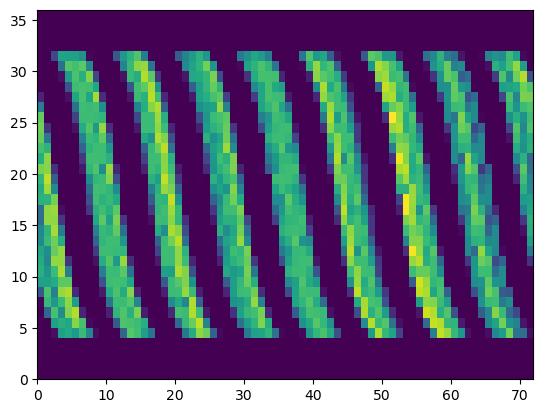

In [253]:
plt.pcolormesh(data["tiwp_isccp_cts"][1])

In [191]:
files = sorted(list(Path("/data/ccic/collocations/monthly").glob("*.nc")))
data = []
for path in files:
    dataset = xr.load_dataset(path)
    parts = path.name.split("_")
    year = int(parts[-2])
    month = int(parts[-1][:-3])
    dataset["time"] = np.datetime64(f"{year}-{(month + 1):02}-01", "ns")
    data.append(dataset)
data = xr.concat(data, "time")

In [278]:
prods = ["ref", "modis", "ccic", "isccp", "patmosx", "dardar"]
means = xr.Dataset({
    prod: data[f"tiwp_{prod}_sum"] / data[f"tiwp_{prod}_cts"] for prod in prods
})
means["latitude"] = (("latitude", lats))
weights = np.cos(np.deg2rad(means.latitude))

In [279]:
spatial_means = means.weighted(weights).mean(("longitude", "latitude"))

In [280]:
LAT_BINS = np.linspace(-90, 90, N_LATS + 1)
lats = 0.5 * (LAT_BINS[1:] + LAT_BINS[:-1])

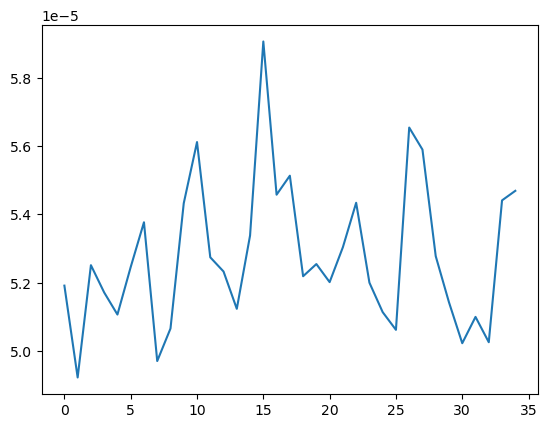

In [281]:
plt.plot(spatial_means["modis"] / 1e3, label="PATMOS-x")

Text(0.5, 1.0, 'Monthly means')

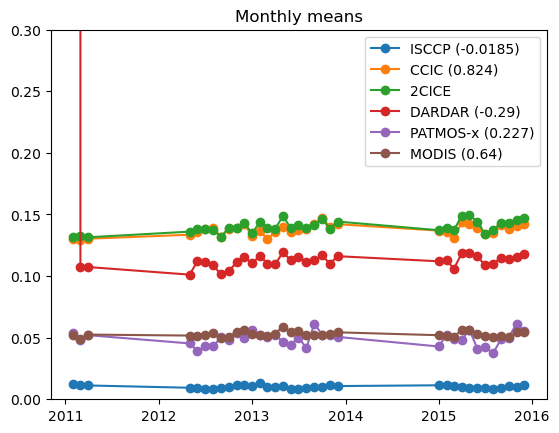

In [282]:
corr_ccic = np.corrcoef(spatial_means["ccic"].data, spatial_means["ref"].data)[0, 1]
corr_isccp = np.corrcoef(spatial_means["isccp"].data, spatial_means["ref"].data)[0, 1]
corr_dardar = np.corrcoef(spatial_means["dardar"].data, spatial_means["ref"].data)[0, 1]
corr_patmosx = np.corrcoef(spatial_means["patmosx"].data, spatial_means["ref"].data)[0, 1]
corr_modis = np.corrcoef(spatial_means["modis"].data, spatial_means["ref"].data)[0, 1]

x = spatial_means.time
plt.plot(x, spatial_means["isccp"], label=f"ISCCP ({corr_isccp:0.3})", marker="o")
plt.plot(x, spatial_means["ccic"], label=f"CCIC ({corr_ccic:0.3})", marker="o")
plt.plot(x, spatial_means["ref"], label="2CICE", marker="o")
plt.plot(x, spatial_means["dardar"], label=f"DARDAR ({corr_dardar:0.3})", marker="o")
plt.plot(x, spatial_means["patmosx"] / 1e3, label=f"PATMOS-x ({corr_patmosx:0.3})", marker="o")
plt.plot(x, spatial_means["modis"], label=f"MODIS ({corr_modis:0.3})", marker="o")
plt.ylim(0, 0.3)
plt.legend()
plt.title("Monthly means")

In [219]:
zonal_means = means.weighted(weights).mean(("longitude", "time"))

In [271]:
zonal_means.latitude

<xarray.DataArray 'latitude' (latitude: 36)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])
Dimensions without coordinates: latitude

Text(0, 0.5, 'TIWP [kg / m$^{-2}$]')

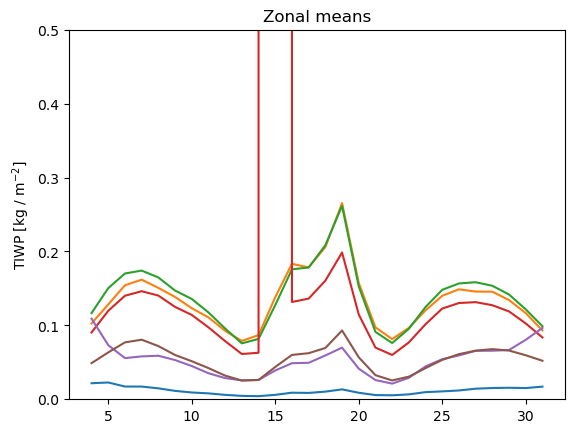

In [269]:
x = zonal_means.latitude
plt.plot(x, zonal_means.isccp)
plt.plot(x, zonal_means.ccic)
plt.plot(x, zonal_means["ref"])
plt.plot(x, zonal_means["dardar"])
plt.plot(x, zonal_means["patmosx"] / 1e3)
plt.plot(x, zonal_means["modis"])
plt.title("Zonal means")
plt.ylim(0, 0.5)
plt.ylabel("TIWP [kg / m$^{-2}$]")

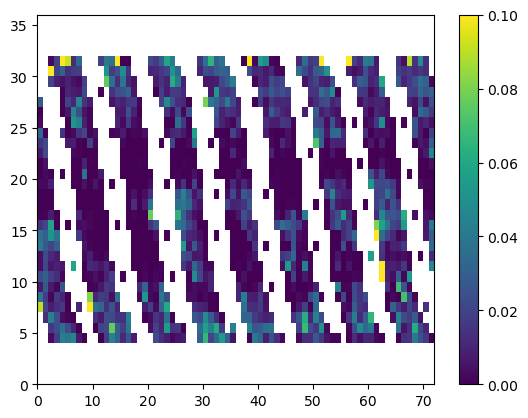

In [167]:
plt.pcolormesh(data.tiwp_isccp_sum / data.tiwp_isccp_cts, vmin=0, vmax=0.1)
plt.colorbar()

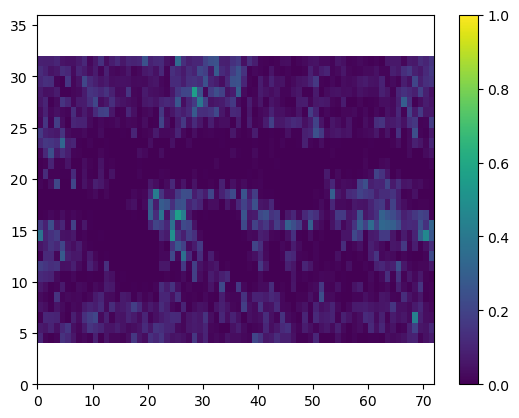

In [174]:
plt.pcolormesh(data.tiwp_modis_sum / data.tiwp_modis_cts, vmin=0, vmax=1)
plt.colorbar()

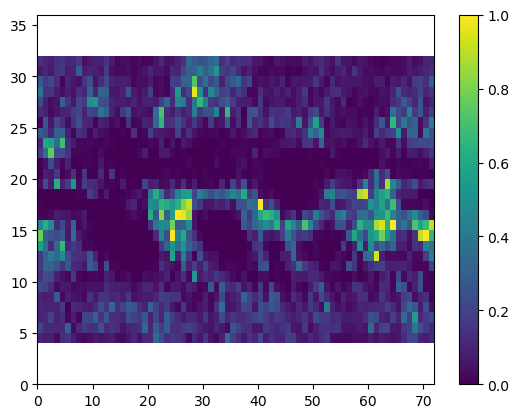

In [171]:
plt.pcolormesh(data.tiwp_ccic_sum / data.tiwp_ccic_cts, vmin=0, vmax=1)
plt.colorbar()

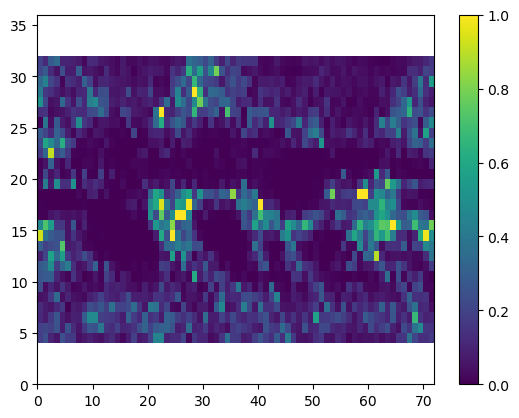

In [173]:
plt.pcolormesh(data.tiwp_ref_sum / data.tiwp_ref_cts, vmin=0, vmax=1)
plt.colorbar()

In [15]:
cs_data = xr.load_dataset(cloudsat_granules[granule])
cs_data = cs_data.rename(
    iwp_ccic="tiwp_ccic",
    iwp_2cice="tiwp_2cice",
    iwp_dardar="tiwp_dardar"
)
cs_data["tiwp_modis"] = get_tiwp_modis(xr.load_dataset(modis_granules[granule])).interp(time=cs_data.time)
cs_data["tiwp_isccp"] = get_tiwp_isccp(xr.load_dataset(isccp_granules[granule]))
cs_data["tiwp_patmosx"] = get_tiwp_patmosx(xr.load_dataset(patmosx_granules[granule]))

(0.01, 10.0)

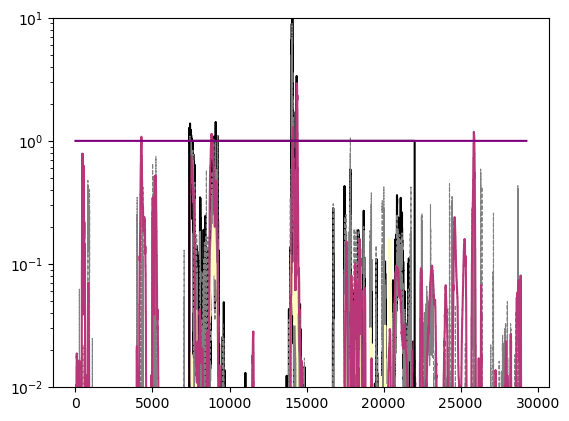

In [27]:
from matplotlib.cm import magma

colors = [magma(x) for x in np.linspace(0, 1, 7)]

f, ax = plt.subplots(1, 1)

ax.plot(cs_data.tiwp_2cice, c="k")
ax.plot(cs_data.tiwp_dardar, c="grey", ls="--", lw=0.8)

ax.plot(cs_data.tiwp_isccp, c=colors[-1])
#ax.plot(cs_data.tiwp_modis, c=colors[1])
#ax.plot(cs_data.tiwp_patmosx, c=colors[2])
ax.plot(cs_data.tiwp_ccic, c=colors[3])
plt.plot(np.isfinite(cs_data.cloud_mask_2cice.data), c="k")
plt.plot(np.isfinite(cs_data.cloud_mask_dardar.data), c="purple")
ax.set_yscale("log")
ax.set_ylim(1e-2, 1e1)

##

In [176]:
cs_data_t = cs_data.reindex({"rays": cs_data.time})
cs_data_t.interp(rays=tiwp_modis.time)

<xarray.Dataset>
Dimensions:            (rays: 28146)
Coordinates:
    longitude          (rays) float64 nan nan nan nan nan ... nan nan nan nan
    latitude           (rays) float64 nan nan nan nan nan ... nan nan nan nan
  * rays               (rays) datetime64[ns] 2014-01-14T18:00:25 ... 2014-01-...
    time               (rays) datetime64[ns] 2014-01-14T18:00:25 ... 2014-01-...
Data variables:
    iwp_ccic           (rays) float64 nan nan nan nan nan ... nan nan nan nan
    iwp_2cice          (rays) float64 nan nan nan nan nan ... nan nan nan nan
    iwp_dardar         (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_ccic    (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    cloudsat_granule:    41048
    cloudsat_timestamp:  2014014180017

In [102]:
cloudsat_granules[granule]

PosixPath('/home/simonpf/sun/cloudsat_hanna/output2/ccicgridsat_dardar_2cice_2014014180017_41048.nc')

In [98]:
cs_data.latitude.max()

<xarray.DataArray 'latitude' ()>
array(68.99603, dtype=float32)

In [154]:
tiwp_modis.time.data.min()
cs_data.time.data.max()

numpy.datetime64('2014-01-14T19:39:10.179687500')

In [149]:
np.diff(cs_data.time).max()

numpy.timedelta64(642078125000,'ns')

In [51]:
k

<xarray.Dataset>
Dimensions:                        (rays: 37082, modis_pixels: 15,
                                    modis_granule: 22)
Coordinates:
  * rays                           (rays) int64 0 1 2 3 ... 37079 37080 37081
  * modis_pixels                   (modis_pixels) int64 0 1 2 3 ... 11 12 13 14
  * modis_granule                  (modis_granule) int64 0 1 2 3 ... 18 19 20 21
    latitude                       (rays, modis_pixels) float32 0.02063 ... -...
    longitude                      (rays, modis_pixels) float32 116.5 ... 91.84
    time                           (rays) datetime64[ns] 2014-01-14T18:00:25 ...
Data variables:
    cloud_phase                    (rays, modis_pixels) int8 0 0 0 0 ... 0 0 0 0
    cloud_phase_scale_factor       (modis_granule) float64 1.0 1.0 ... -999.0
    cloud_phase_offset             (modis_granule) float64 0.0 0.0 ... -999.0
    cloud_water_path               (rays, modis_pixels) int16 -9999 ... -9999
    cloud_water_path_offset        (modis_granule) float64 0.0 0.0 ... -999.0
    cloud_water_path_scale_factor  (modis_granule) float64 1.0 1.0 ... -999.0
    modis_granule_index            (rays, modis_pixels) int8 1 1 1 ... 21 21 21

In [41]:
cs_data = xr.load_dataset(cloudsat_granules[granule])

In [84]:
modis_data = xr.load_dataset(modis_granules[granule])[{"modis_pixels": 7}]
modis_data = modis_data.reindex({"rays": modis_data.time})


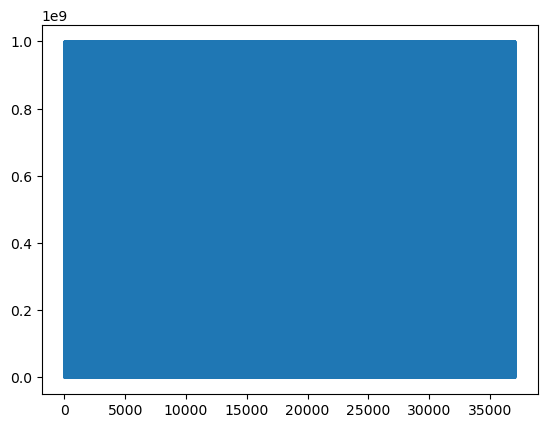

In [88]:
plt.plot(np.diff(modis_data.rays))

In [78]:
np.diff(cs_data.time).max()

numpy.timedelta64(642078125000,'ns')

In [86]:
modis_data = modis_data.interp(rays=cs_data.time)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

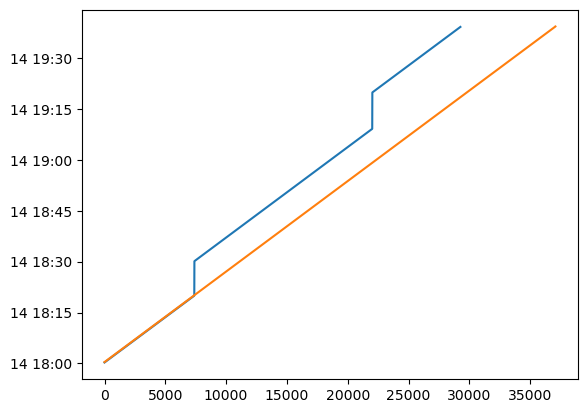

In [70]:
plt.plot(cs_data.time)
plt.plot(modis_data.rays)

In [214]:
granule = next(iter(common))

data = xr.load_dataset(cloudsat_granules[granule])[["iwp_ccic", "iwp_2cice", "iwp_dardar"]]
data["tiwp_modis"] = get_tiwp_modis(xr.load_dataset(modis_granules[granule])).interp(time=data.time)
data["tiwp_isccp"] = get_tiwp_isccp(xr.load_dataset(isccp_granules[granule]))

[29267 29267 29267 29267 29267 29267 29267 29267 29267 29267 29267 29267
 29267 29267 29267 29267 29267 29267]
[15978 15978 15978 15978 15978 15978 15978 15978 15978 15978 15978 15978
 15978 15978 15978 15979 15978 15978]


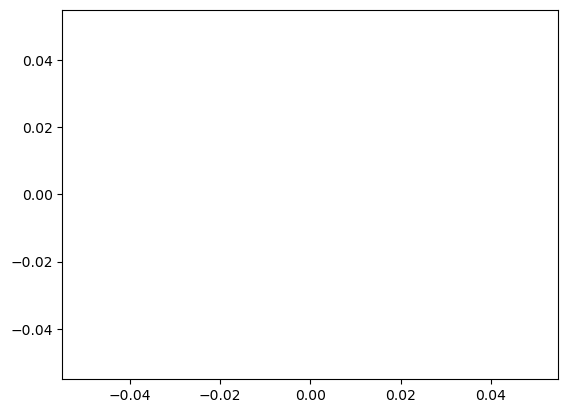

In [217]:
#plt.plot(data.tiwp_modis)
plt.plot(data.tiwp_isccp)

In [5]:
modis_files = sorted(list(Path("/data/ccic/collocations/modis/").glob("modis_2015*")))

In [8]:
tiwp_modis = get_tiwp_modis(xr.load_dataset(modis_files[0]))

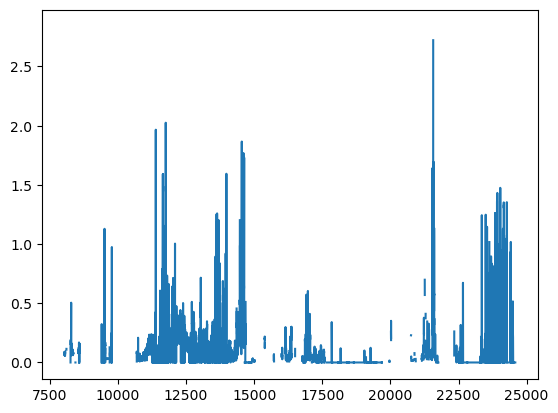

In [10]:
plt.plot(tiwp_modis)

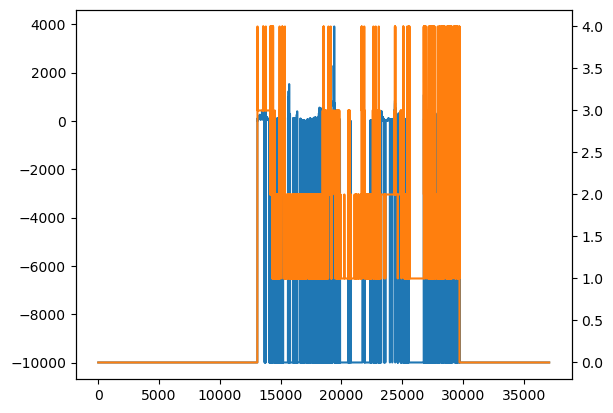

In [34]:
plt.plot(modis_data.cloud_water_path[{"modis_pixels": 8}])
plt.twinx()
plt.plot(modis_data.cloud_phase[{"modis_pixels": 8}], c="C1")

In [38]:
tiwp.mean()

<xarray.DataArray ()> Size: 4B
array(64.16612, dtype=float32)

In [46]:
valid = np.isfinite(tiwp.data)
tiwp_valid = tiwp.data[valid]
(tiwp_valid > 0).mean()

0.6458821690889202

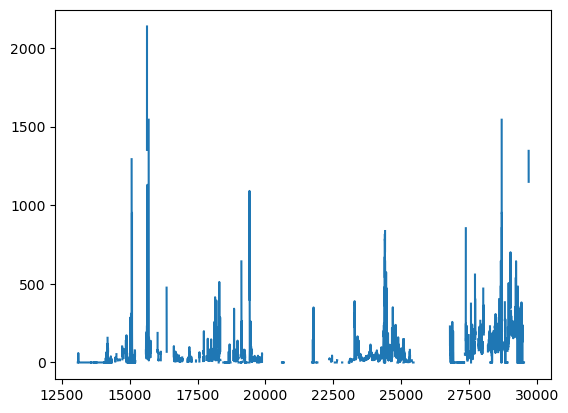

In [35]:
tiwp = get_tiwp_modis(modis_data)
plt.plot(tiwp)

In [56]:
GRANULE_PATH = Path("/data/ccic/collocations")
modis_collocations = find_granules(GRANULE_PATH / "modis")
isccp_collocations = find_granules(GRANULE_PATH / "isccp")
patmosx_collocations = find_granules(GRANULE_PATH / "patmosx")

In [59]:
patmosx_data = xr.load_dataset(next(iter(patmosx_collocations.values())))

In [60]:
patmosx_data

<xarray.Dataset> Size: 3MB
Dimensions:                     (rays: 37081)
Coordinates:
    time                        datetime64[ns] 8B 2014-12-31
    latitude                    (rays) float64 297kB -0.002947 ... 0.008887
    longitude                   (rays) float64 297kB 28.49 28.48 ... 3.769 3.766
  * rays                        (rays) int64 297kB 0 1 2 3 ... 37078 37079 37080
    surface_elevation           (rays) int64 297kB 938 953 952 ... -9999 -9999
Data variables:
    scan_line_time              (rays) datetime64[ns] 297kB 2015-01-01T00:41:...
    cloud_fraction              (rays) float64 297kB 1.0 1.0 1.0 ... 1.0 1.0 1.0
    cloud_fraction_uncertainty  (rays) float64 297kB 0.06385 ... 0.0003836
    cloud_mask                  (rays) float64 297kB 2.491 2.458 ... 3.0 3.0
    cld_cwp_dcomp               (rays) float64 297kB nan nan nan ... nan nan nan
    dcomp_quality               (rays) float64 297kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ice_cloud_probability       (rays) float64 297kB 0.4198 0.4169 ... 0.7832
Attributes: (12/99)
    summary:                               Included in this file are PATMOS-x...
    institution:                           NOAA/NESDIS and the University of ...
    cdr_program:                           NOAA Climate Data Record Program
    title:                                PATMOS-x AVHRR reflectance, brightn...
    keywords:                             Earth Science > Atmosphere > Atmosp...
    keywords_vocabulary:                  NASA Global Change Master Directory...
    ...                                   ...
    MEAN_TEMPERATURE_3_750UM_NOM:         267.9732663350061
    _History:                             
    product_version:                      v06r00
    HIRSAVHRR_tpw_rtvl_product_version:   v01r01
    HIRSAVHRR_tpw_rtvl_date_issued:       2019-03-01
    HIRSAVHRR_TPW_coef_fn:                HIRS_AVHRR_TPW_regcoef_metop_2_shif...

In [ ]:
modis_granules = find_granules("/data/ccic/collocations/modis/")
dardar_granules = find_granules("/home/simonpf/sun/cloudsat_hanna/output")
common = set(modis_granules.keys()).intersection(set(dardar_granules.keys()))

In [ ]:
modis_data = xr.load_dataset(modis_granules[next(iter(common))])
dardar_data = xr.load_dataset(dardar_granules[next(iter(common))])

In [5]:
modis_iwp = modis_data.cloud_water_path.data.copy()

NameError: name 'modis_data' is not defined

In [50]:
from scipy.ndimage import gaussian_filter_1d
iwp_dardar = dardar_data.iwp_dardar.data


ModuleNotFoundError: No module named 'scipy'

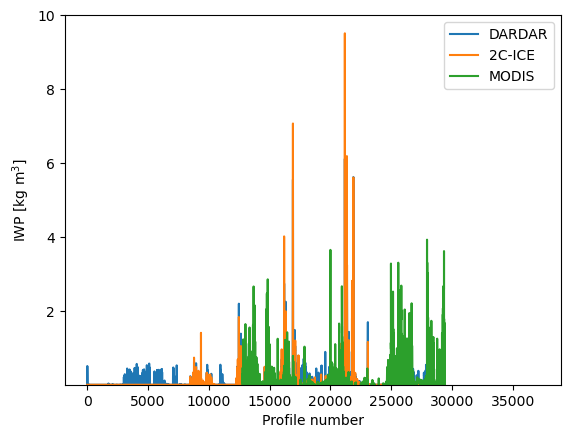

In [54]:
plt.plot(dardar_data.iwp_dardar, label="DARDAR")
plt.plot(dardar_data.iwp_2cice, label="2C-ICE")
#plt.plot(dardar_data.iwp_ccic, label="CCIC")
plt.plot(modis_data.cloud_water_path[{"modis_pixels": 8}] / 1e3, label="MODIS")
plt.ylim([1e-3, 1e1])
plt.xlabel("Profile number")
plt.ylabel("IWP [kg m$^3]$")

plt.legend()

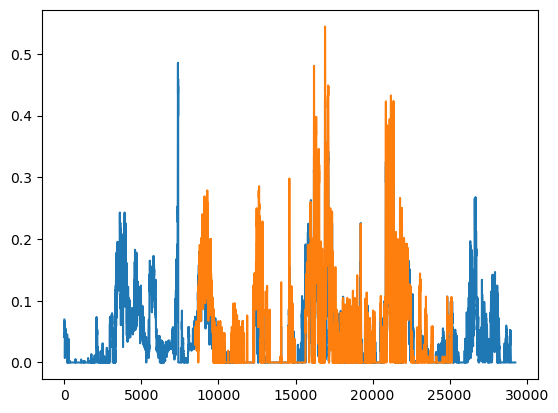

In [47]:
plt.plot(dardar_data.cloud_mask_dardar)
plt.plot(dardar_data.cloud_mask_2cice)
